In [11]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
df = pd.read_csv("events.csv", parse_dates=["request_time", "start_time", "finish_time"])

In [13]:

df["response_delay"] = (df["start_time"] - df["request_time"]).dt.total_seconds() / 60
df["handling_time"] = (df["finish_time"] - df["start_time"]).dt.total_seconds() / 60
df["total_time"] = (df["finish_time"] - df["request_time"]).dt.total_seconds() / 60

In [14]:
# Позначки SLA
df["over_handling_SLA"] = df["handling_time"] < 5
df["over_response_SLA"] = df["response_delay"] < 15
df["over_total_SLA"] = df["total_time"] < 45

In [15]:
df.head()

,moderator,id_request,request_time,start_time,finish_time,team,response_delay,handling_time,total_time,over_handling_SLA,over_response_SLA,over_total_SLA
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail,10619.250000,1.516667,10620.766667,True,False,False
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail,9529.450000,0.016667,9529.466667,True,False,False
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale,10599.050000,4.666667,10603.716667,True,False,False
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail,9938.950000,2.400000,9941.350000,True,False,False
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail,2381.416667,10.400000,2391.816667,False,False,False


In [16]:
# Категоризація запитів за часом відповіді (в хвилинах)
df["response_category"] = pd.cut(
    df["response_delay"],
    bins=[0, 15, 45, float("inf")],
    labels=["до 15 хв", "15-45 хв", "понад 45 хв"],
    right=True
)

# частки
share_under_15 = (df["response_category"] == "до 15 хв").mean()
share_15_to_45 = (df["response_category"] == "15-45 хв").mean()
share_over_45 = (df["response_category"] == "понад 45 хв").mean()

print(f"Частка звернень з відповіддю до 15 хв: {share_under_15:.2%}")
print(f"Частка звернень з відповіддю між 15-45 хв: {share_15_to_45:.2%}")
print(f"Частка звернень з відповіддю понад 45 хв: {share_over_45:.2%}")


Частка звернень з відповіддю до 15 хв: 8.06%
Частка звернень з відповіддю між 15-45 хв: 13.59%
Частка звернень з відповіддю понад 45 хв: 78.34%


In [17]:
df.groupby("team")[["response_delay", "handling_time", "total_time"]].mean()

,response_delay,handling_time,total_time
team,,,
retail,607.786440,1.977244,609.763684
wholesale,3677.494648,2.415659,3679.910307


In [18]:
moderator_summary = df.groupby("moderator").agg(
    avg_response_delay=('response_delay', 'mean'),
    avg_handling_time=('handling_time', 'mean'),
    avg_total_time=('total_time', 'mean'),
    total_requests=('id_request', 'count')
).reset_index()

moderator_summary['team'] = df.drop_duplicates('moderator')[['moderator', 'team']].set_index('moderator').loc[moderator_summary['moderator'], 'team'].values

print(moderator_summary.sort_values("total_requests", ascending=False))


    moderator  avg_response_delay  avg_handling_time  avg_total_time  \
48        188         4058.972153           1.232128     4060.204280   
5         112         4382.390992           2.281130     4384.672122   
36        170         3883.557661           2.428420     3885.986081   
44        181         4692.149733           2.795928     4694.945662   
11        123         3762.907828           3.057289     3765.965117   
43        180         4579.584470           1.908463     4581.492933   
46        186          606.537121           2.008594      608.545715   
0         102         3714.671625           1.855021     3716.526646   
1         103         3000.176085           2.294161     3002.470246   
8         117          454.777764           1.710205      456.487970   
47        187         4372.228444           3.074183     4375.302626   
12        125         3620.503883           2.654581     3623.158464   
38        172          591.040821           1.883950      592.92

Команда: retail
Модератори з кількістю запитів менше за середню:
    moderator first_request  total_requests
1         110    2020-10-01               1
2         111    2020-10-05             569
3         114    2020-10-01              60
6         133    2020-10-09               2
7         134    2020-10-07               8
10        138    2020-10-01               1
13        150    2020-10-09              16
14        152    2020-10-03             477
18        167    2020-10-01             536




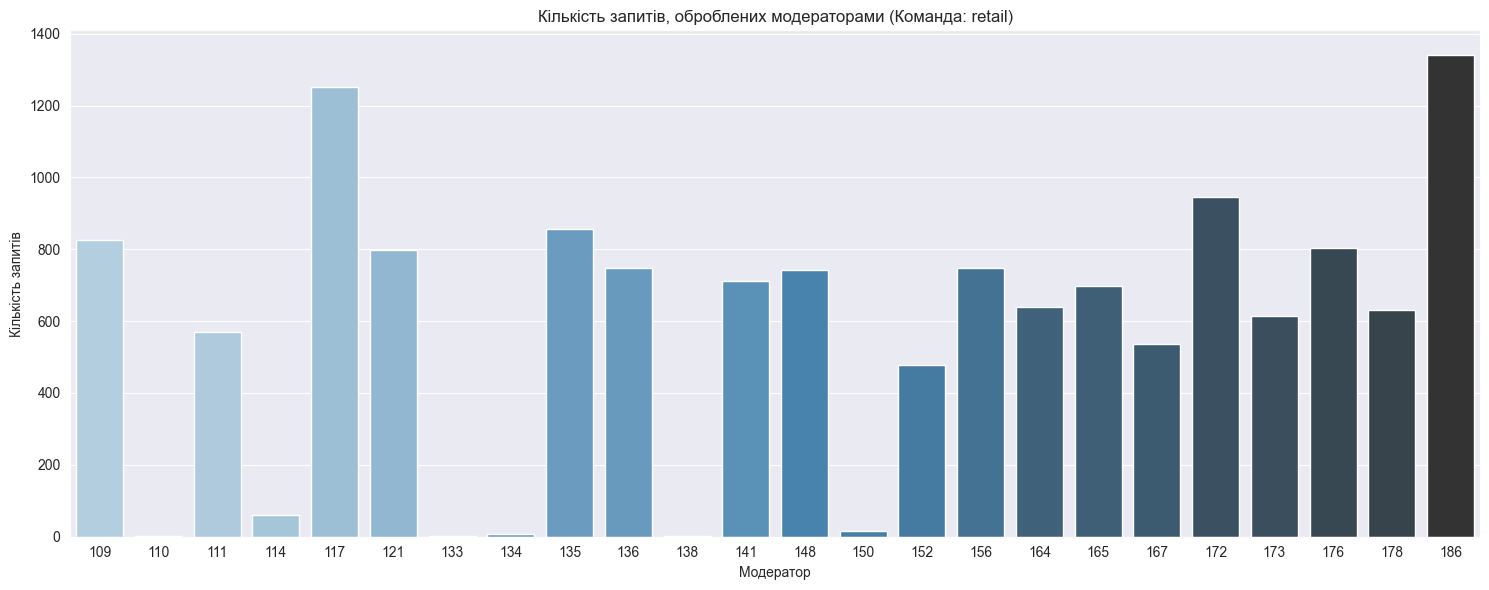

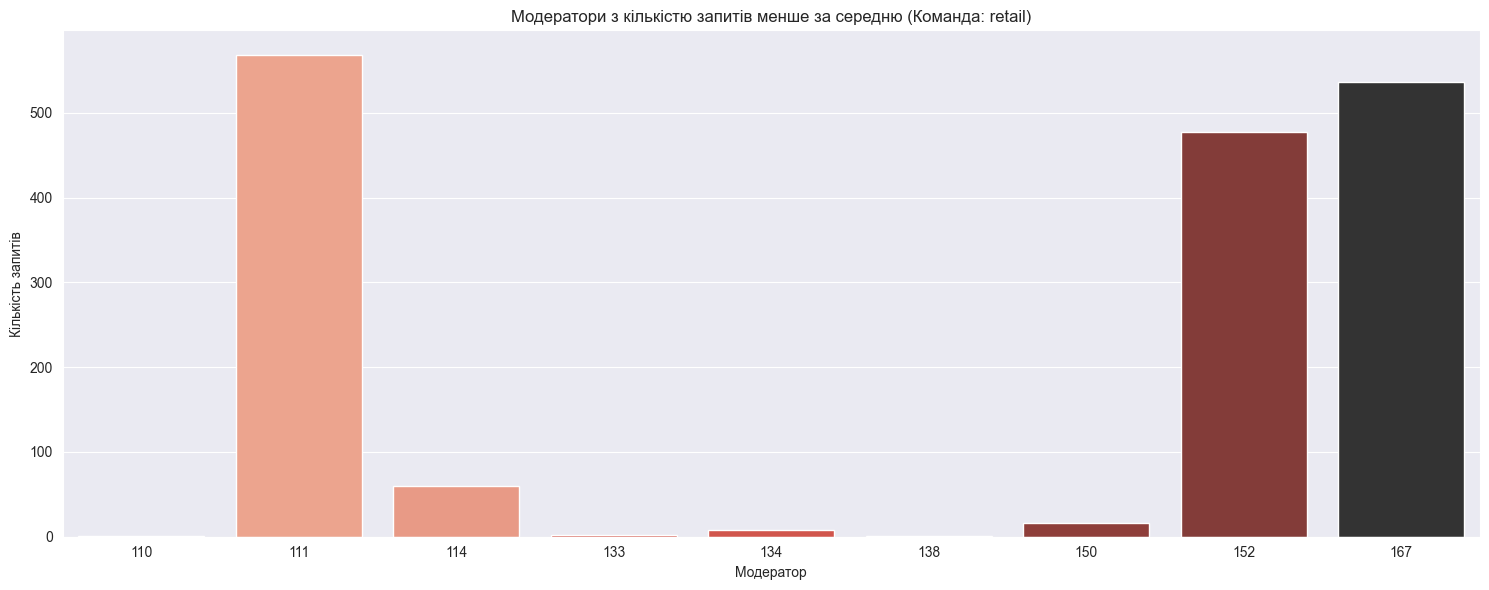

Команда: wholesale
Модератори з кількістю запитів менше за середню:
    moderator first_request  total_requests
27        116    2020-10-01             580
28        122    2020-10-03             767
31        126    2020-12-02               2
32        128    2020-10-01             237
33        129    2020-10-01               1
34        143    2020-10-03             141
35        144    2020-10-01              61
37        149    2020-10-03             751
38        153    2020-10-01             838
39        161    2020-10-01             181
40        163    2020-10-03             130
42        171    2020-10-03               1
43        175    2020-10-04             420
46        185    2020-11-24              25




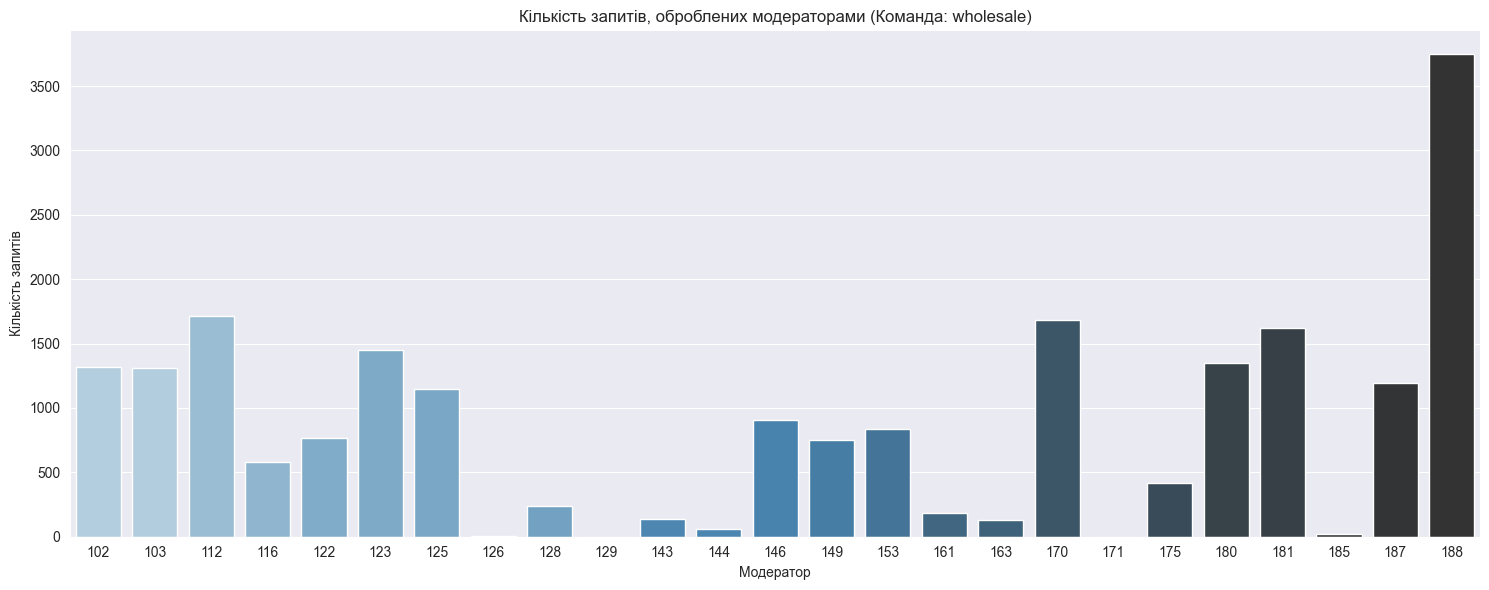

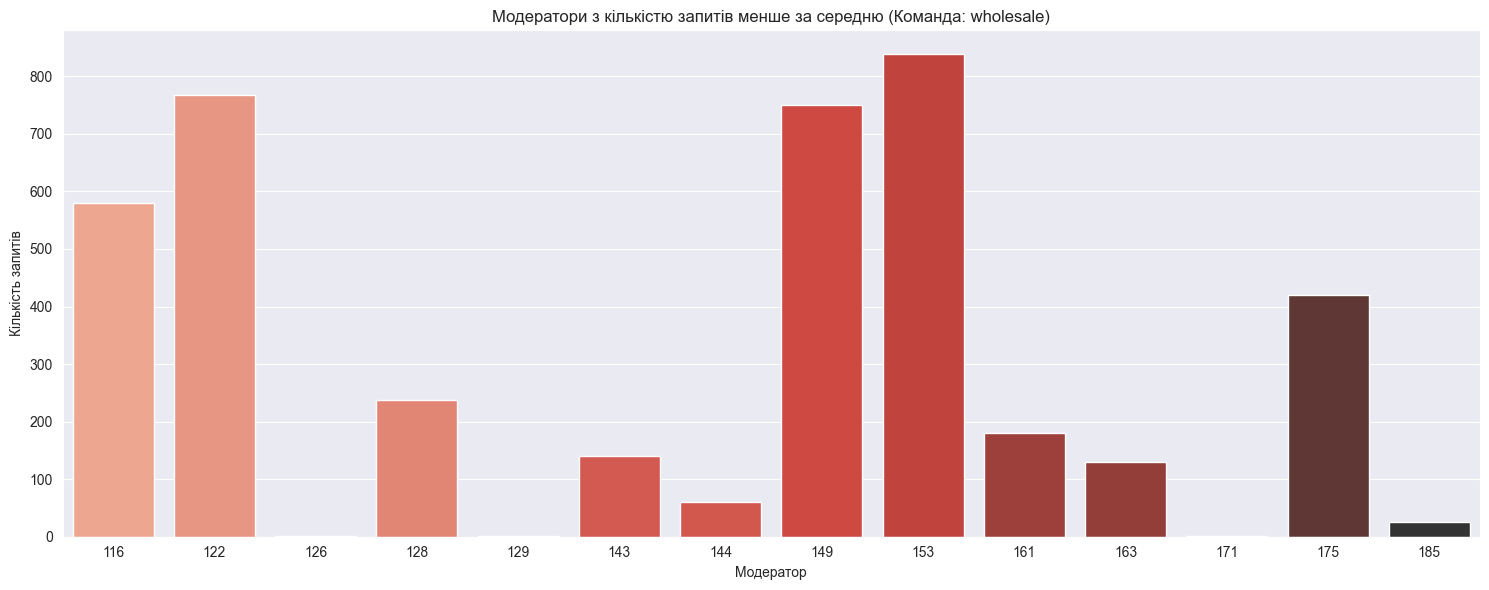

In [19]:
# нові стовпці для часу
df['request_date'] = df['request_time'].dt.date

# Групую по команді та модератору, щоб визначити кількість запитів і перший запит
moderator_summary = df.groupby(['team', 'moderator']).agg(
    first_request=('request_date', 'min'),
    total_requests=('moderator', 'count')
).reset_index()

# Для кожної команди середнє значення кількості запитів
for team in moderator_summary['team'].unique():
    team_data = moderator_summary[moderator_summary['team'] == team]

    avg_requests = team_data['total_requests'].mean()
    # Фільтрація модераторів
    filtered_mods = team_data[team_data['total_requests'] < avg_requests]

    print(f"Команда: {team}")
    print("Модератори з кількістю запитів менше за середню:")
    print(filtered_mods[['moderator', 'first_request', 'total_requests']])
    print("\n")

    plt.figure(figsize=(15, 6))
    sns.barplot(
        x="moderator",
        y="total_requests",
        hue="moderator",
        data=team_data.sort_values("total_requests", ascending=False),
        palette="Blues_d",
        legend=False
    )
    plt.title(f"Кількість запитів, оброблених модераторами (Команда: {team})")
    plt.ylabel("Кількість запитів")
    plt.xlabel("Модератор")
    plt.tight_layout()
    plt.show()

    if not filtered_mods.empty:
        plt.figure(figsize=(15, 6))
        sns.barplot(
            x="moderator",
            y="total_requests",
            hue="moderator",
            data=filtered_mods.sort_values("total_requests", ascending=False),
            palette="Reds_d",
            legend=False
        )
        plt.title(f"Модератори з кількістю запитів менше за середню (Команда: {team})")
        plt.ylabel("Кількість запитів")
        plt.xlabel("Модератор")
        plt.tight_layout()
        plt.show()


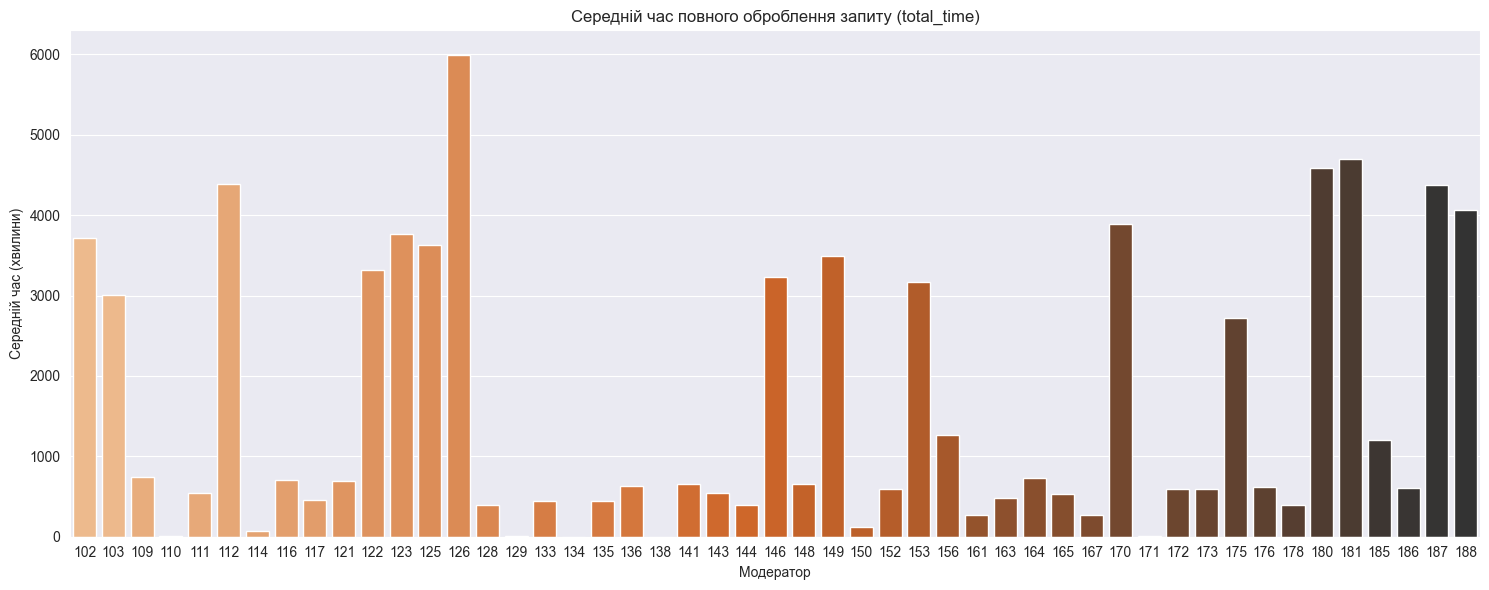

In [22]:
moderator_summary = df.groupby('moderator').agg(
    avg_total_time=('total_time', 'mean'),
    total_requests=('moderator', 'count')
).reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(
    x="moderator",
    y="avg_total_time",
    hue="moderator",
    data=moderator_summary.sort_values("avg_total_time", ascending=False),
    palette="Oranges_d",
    legend=False
)
plt.title("Середній час повного оброблення запиту (total_time)")
plt.xlabel("Модератор")
plt.ylabel("Середній час (хвилини)")
plt.tight_layout()
plt.show()

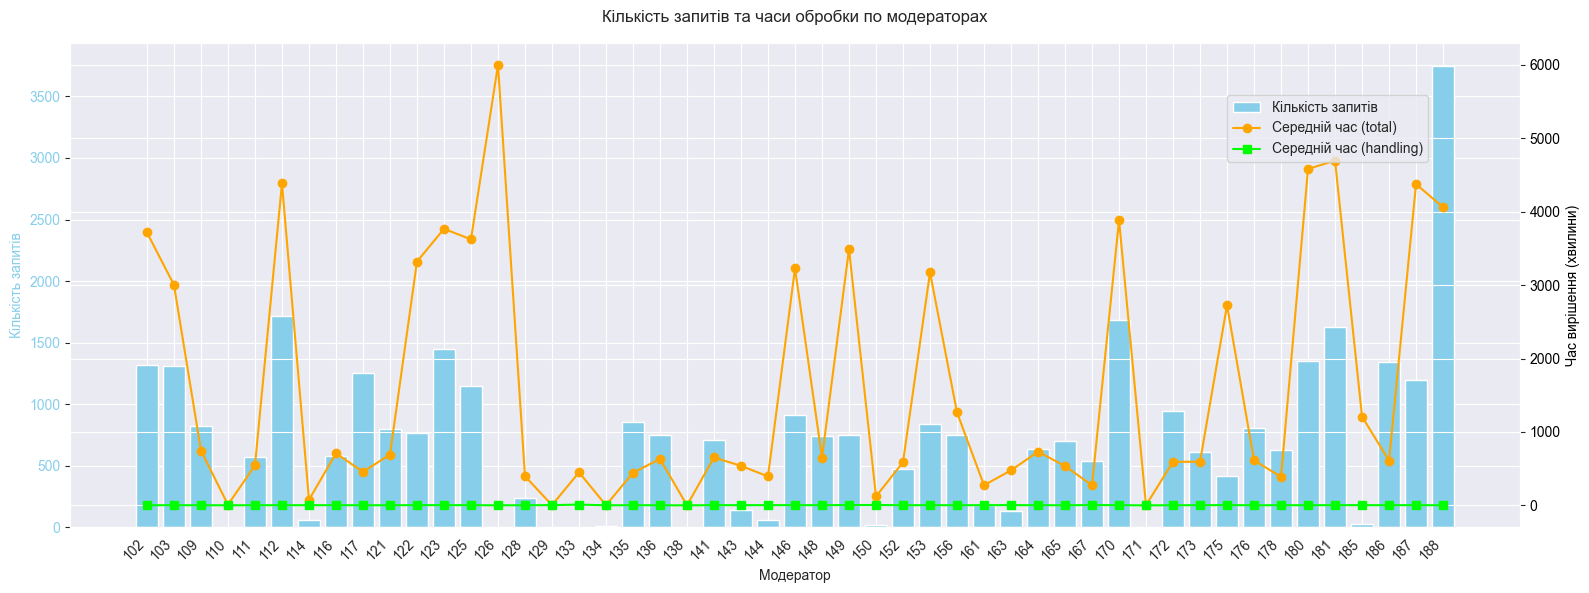

In [14]:
# фіксований порядок для модераторів
moderators = moderator_summary["moderator"].tolist()
x = np.arange(len(moderators))  # [0, 1, 2, ..., N]

fig, ax1 = plt.subplots(figsize=(16, 6))


ax1.bar(x, moderator_summary["total_requests"], color="skyblue", label="Кількість запитів")
ax1.set_ylabel("Кількість запитів", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_xlabel("Модератор")
ax1.set_xticks(x)
ax1.set_xticklabels(moderators, rotation=45, ha="right")


ax2 = ax1.twinx()
ax2.plot(x, moderator_summary["avg_total_time"], label="Середній час (total)", color="orange", marker='o')
ax2.plot(x, moderator_summary["avg_handling_time"], label="Середній час (handling)", color="lime", marker='s')
ax2.set_ylabel("Час вирішення (хвилини)", color="black")
ax2.tick_params(axis='y', labelcolor="black")


fig.suptitle("Кількість запитів та часи обробки по модераторах")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))
plt.tight_layout()
plt.show()


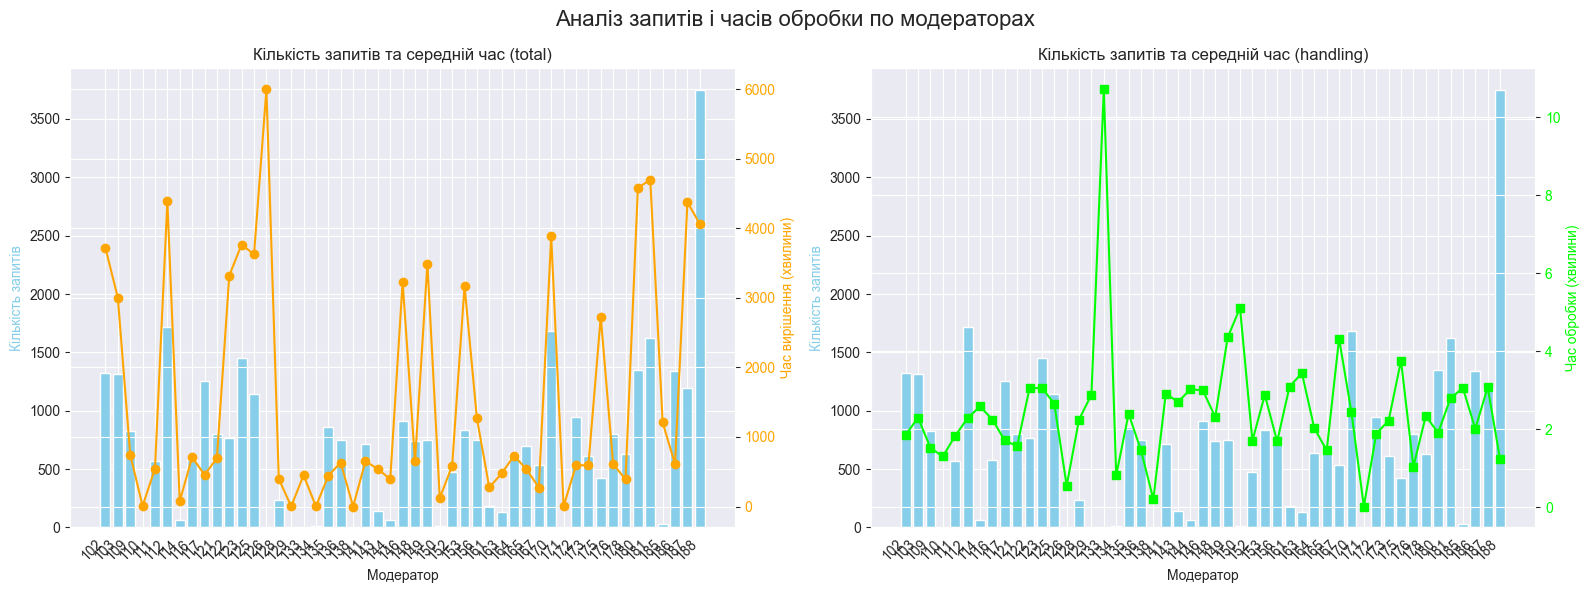

In [15]:
# фіксований порядок для модераторів
moderators = moderator_summary["moderator"].tolist()
x = numpy.arange(len(moderators))  # [0, 1, 2, ..., N]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.bar(x, moderator_summary["total_requests"], color="skyblue", label="Кількість запитів")
ax1.set_ylabel("Кількість запитів", color="skyblue")
ax1.set_xlabel("Модератор")
ax1.set_xticks(x)
ax1.set_xticklabels(moderators, rotation=45, ha="right")
ax1.set_title("Кількість запитів та середній час (total)")


ax1_twin = ax1.twinx()
ax1_twin.plot(x, moderator_summary["avg_total_time"], label="Середній час (total)", color="orange", marker='o')
ax1_twin.set_ylabel("Час вирішення (хвилини)", color="orange")
ax1_twin.tick_params(axis='y', labelcolor="orange")


ax2.bar(x, moderator_summary["total_requests"], color="skyblue", label="Кількість запитів")
ax2.set_ylabel("Кількість запитів", color="skyblue")
ax2.set_xlabel("Модератор")
ax2.set_xticks(x)
ax2.set_xticklabels(moderators, rotation=45, ha="right")
ax2.set_title("Кількість запитів та середній час (handling)")


ax2_twin = ax2.twinx()
ax2_twin.plot(x, moderator_summary["avg_handling_time"], label="Середній час (handling)", color="lime", marker='s')
ax2_twin.set_ylabel("Час обробки (хвилини)", color="lime")
ax2_twin.tick_params(axis='y', labelcolor="lime")


fig.suptitle("Аналіз запитів і часів обробки по модераторах", fontsize=16)

plt.tight_layout()
plt.show()


In [16]:
# індекс ефективності для кожного модератора
moderator_summary['efficiency'] = moderator_summary['total_requests'] / moderator_summary['avg_handling_time']

# середнє значення ефективності для всіх модераторів
average_efficiency = moderator_summary['efficiency'].mean()


low_efficiency_moderators = moderator_summary[moderator_summary['efficiency'] < average_efficiency]

print(f"Середнє значення ефективності: {average_efficiency:.2f}")
print("Модератори, чий індекс ефективності менший за середнє:")
print(low_efficiency_moderators[['moderator', 'efficiency', 'total_requests', 'avg_handling_time']])


Середнє значення ефективності: 363.21
Модератори, чий індекс ефективності менший за середнє:
    moderator  efficiency  total_requests  avg_handling_time
3         110    0.769231               1           1.300000
4         111  310.631636             569           1.831752
6         114   23.213326              60           2.584722
7         116  258.028227             580           2.247816
10        122  251.647524             767           3.047914
13        126    3.636364               2           0.550000
14        128  105.428893             237           2.247961
15        129    0.346821               1           2.883333
16        133    0.186625               2          10.716667
17        134    9.820972               8           0.814583
18        135  357.744277             857           2.395566
20        138    5.000000               1           0.200000
21        141  245.060096             713           2.909490
22        143   52.233656             141           2

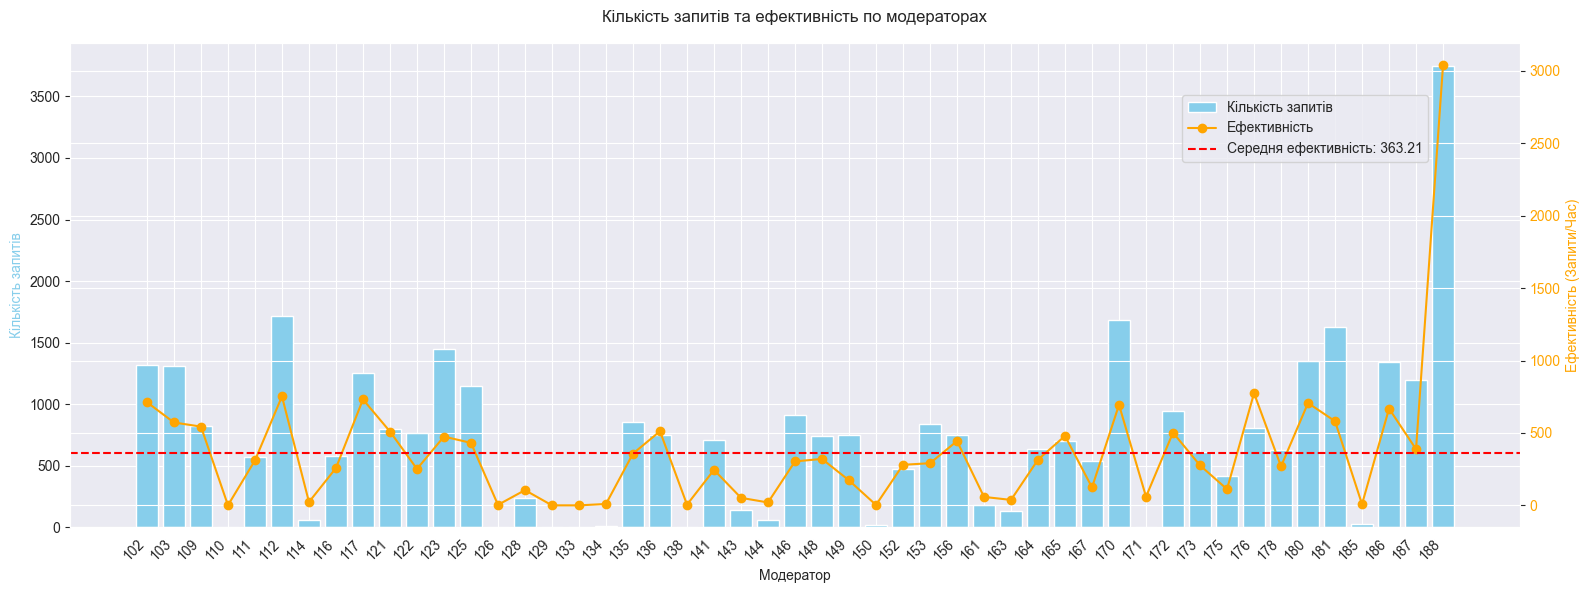

In [17]:
moderators = moderator_summary["moderator"].tolist()
x = np.arange(len(moderators))  # [0, 1, 2, ..., N]

# індекс ефективності
moderator_summary['efficiency'] = moderator_summary['total_requests'] / moderator_summary['avg_handling_time']

# Середнє значення ефективності
average_efficiency = moderator_summary['efficiency'].mean()

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.bar(x, moderator_summary["total_requests"], color="skyblue", label="Кількість запитів")
ax1.set_ylabel("Кількість запитів", color="skyblue")
ax1.set_xlabel("Модератор")
ax1.set_xticks(x)
ax1.set_xticklabels(moderators, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(x, moderator_summary["efficiency"], label="Ефективність", color="orange", marker='o')
ax2.set_ylabel("Ефективність (Запити/Час)", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# лінія середнього значення ефективності
ax2.axhline(y=average_efficiency, color="red", linestyle='--', label=f"Середня ефективність: {average_efficiency:.2f}")

fig.suptitle("Кількість запитів та ефективність по модераторах")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.tight_layout()
plt.show()


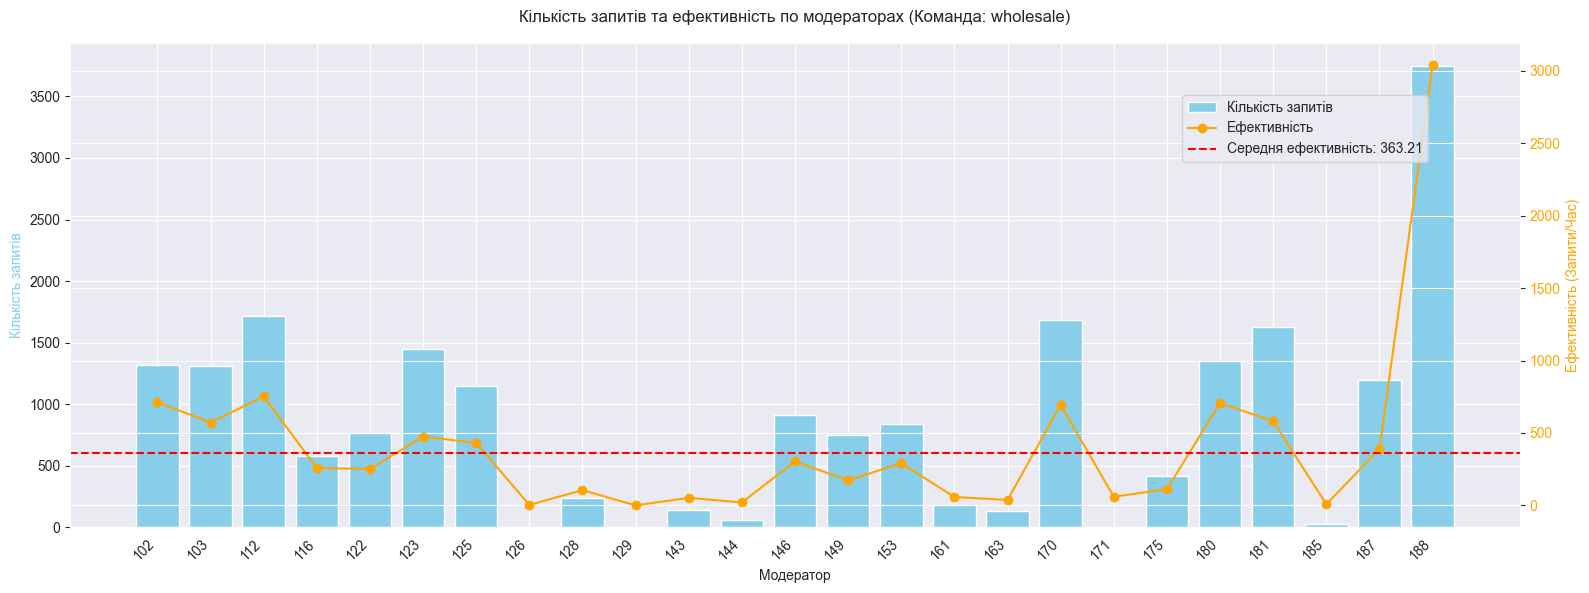

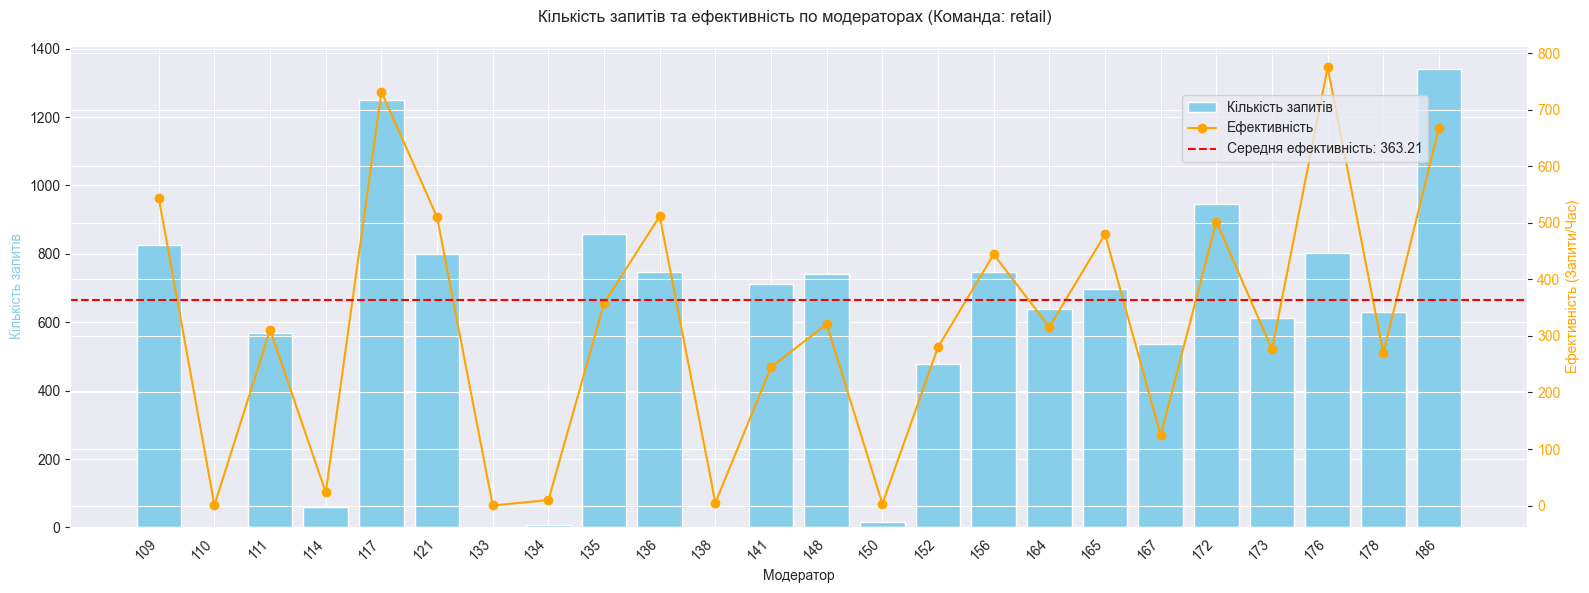

In [18]:
teams = moderator_summary['team'].unique()

# індекс ефективності
moderator_summary['efficiency'] = moderator_summary['total_requests'] / moderator_summary['avg_handling_time']

# Середнє значення ефективності
average_efficiency = moderator_summary['efficiency'].mean()


for team in teams:

    team_data = moderator_summary[moderator_summary['team'] == team]
    moderators = team_data['moderator'].tolist()
    x = np.arange(len(moderators))  # [0, 1, 2, ..., N]


    fig, ax1 = plt.subplots(figsize=(16, 6))

    ax1.bar(x, team_data["total_requests"], color="skyblue", label="Кількість запитів")
    ax1.set_ylabel("Кількість запитів", color="skyblue")
    ax1.set_xlabel("Модератор")
    ax1.set_xticks(x)
    ax1.set_xticklabels(moderators, rotation=45, ha="right")

    ax2 = ax1.twinx()
    ax2.plot(x, team_data["efficiency"], label="Ефективність", color="orange", marker='o')
    ax2.set_ylabel("Ефективність (Запити/Час)", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # лінія середнього значення ефективності
    ax2.axhline(y=average_efficiency, color="red", linestyle='--', label=f"Середня ефективність: {average_efficiency:.2f}")

    fig.suptitle(f"Кількість запитів та ефективність по модераторах (Команда: {team})")
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

    plt.tight_layout()
    plt.show()


In [22]:
# Загальний handling_time для кожного модератора
moderator_work_time = df.groupby("moderator")["handling_time"].sum().reset_index()
moderator_work_time = moderator_work_time.rename(columns={"handling_time": "total_handling_time"})

print(moderator_work_time.sort_values("total_handling_time", ascending=False))


    moderator  total_handling_time
48        188          4615.550000
44        181          4543.383333
11        123          4439.183333
36        170          4094.316667
5         112          3916.700000
47        187          3667.500000
26        149          3267.683333
12        125          3042.150000
1         103          3012.233333
24        146          2720.716667
46        186          2695.533333
43        180          2574.516667
0         102          2450.483333
29        153          2411.216667
10        122          2337.750000
35        167          2315.516667
8         117          2139.466667
21        141          2074.466667
18        135          2053.000000
38        172          1782.216667
25        148          1711.666667
40        175          1577.166667
42        178          1472.950000
39        173          1360.266667
7         116          1303.733333
33        164          1297.116667
30        156          1259.966667
2         109       

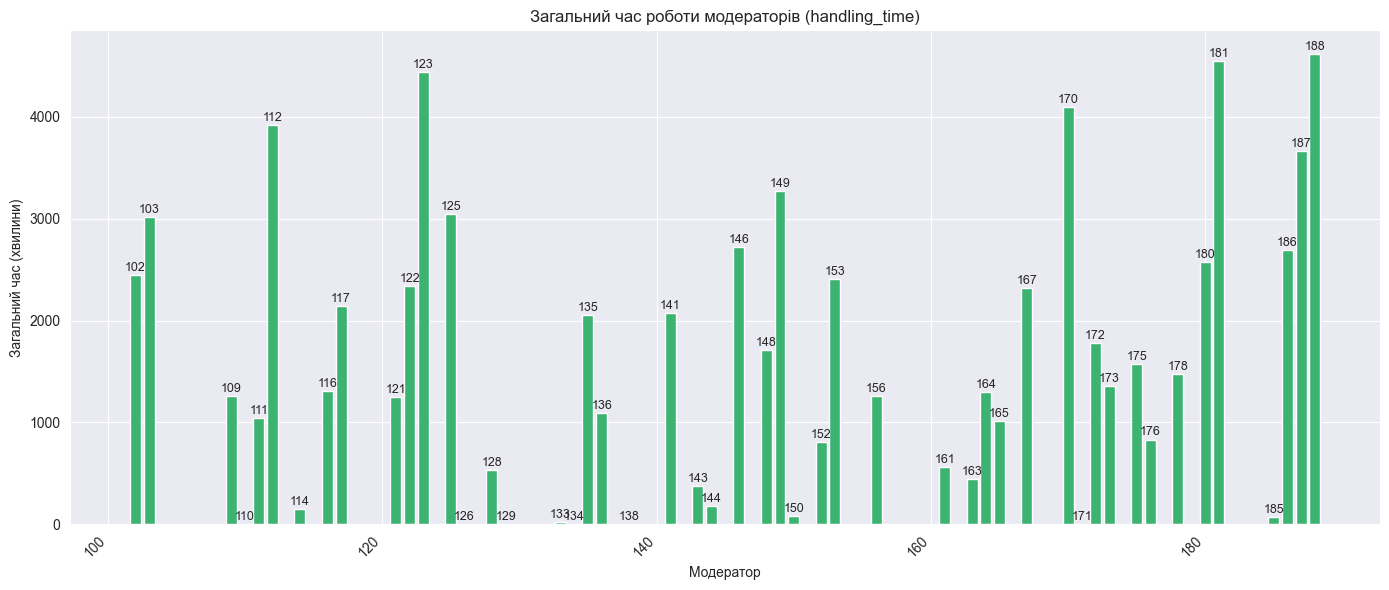

In [23]:
moderator_work_time = df.groupby("moderator")["handling_time"].sum().reset_index()
moderator_work_time = moderator_work_time.rename(columns={"handling_time": "total_handling_time"})
moderator_work_time = moderator_work_time.sort_values("total_handling_time", ascending=False)


plt.figure(figsize=(14, 6))
bars = plt.bar(moderator_work_time["moderator"], moderator_work_time["total_handling_time"], color="mediumseagreen")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10,  # +10 для відступу від стовпчика
             f"{moderator_work_time['moderator'].iloc[i]}",  # підпис іменем модератора
             ha="center", va="bottom", fontsize=9)

plt.title("Загальний час роботи модераторів (handling_time)")
plt.xlabel("Модератор")
plt.ylabel("Загальний час (хвилини)")
plt.xticks(rotation=45, ha="right")  # Повертаємо підписи на осі X, щоб було видно
plt.tight_layout()
plt.show()


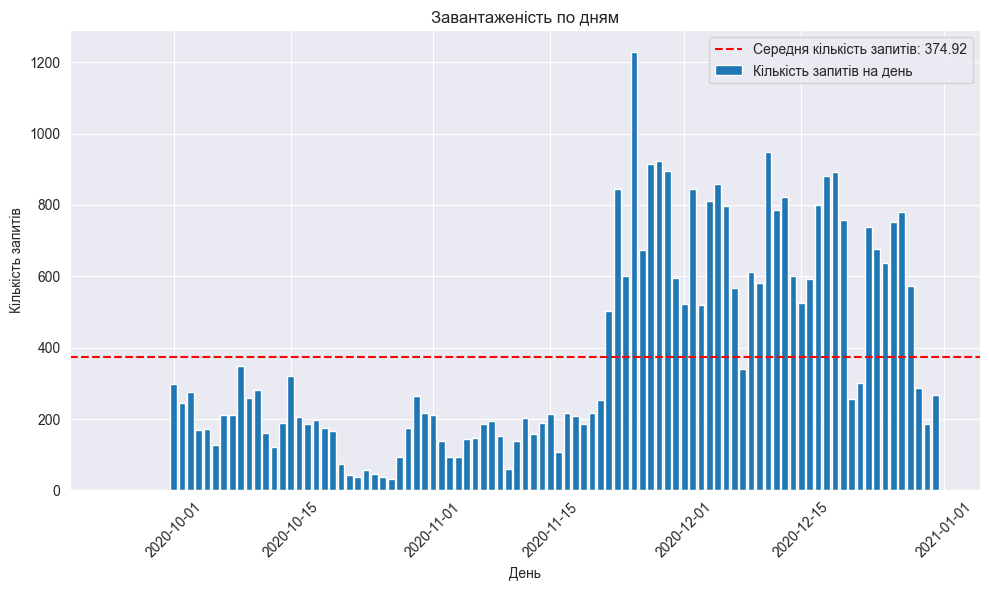

In [24]:
df['request_time'] = pd.to_datetime(df['request_time'])
df['day'] = df['request_time'].dt.date

daily_requests = df.groupby('day').size()

# середню кількість запитів на день
avg_requests = daily_requests.mean()

plt.figure(figsize=(10, 6))

plt.bar(daily_requests.index, daily_requests.values, label='Кількість запитів на день')

plt.axhline(avg_requests, color='red', linestyle='--', label=f'Середня кількість запитів: {avg_requests:.2f}')

plt.xlabel('День')
plt.ylabel('Кількість запитів')
plt.title('Завантаженість по дням')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


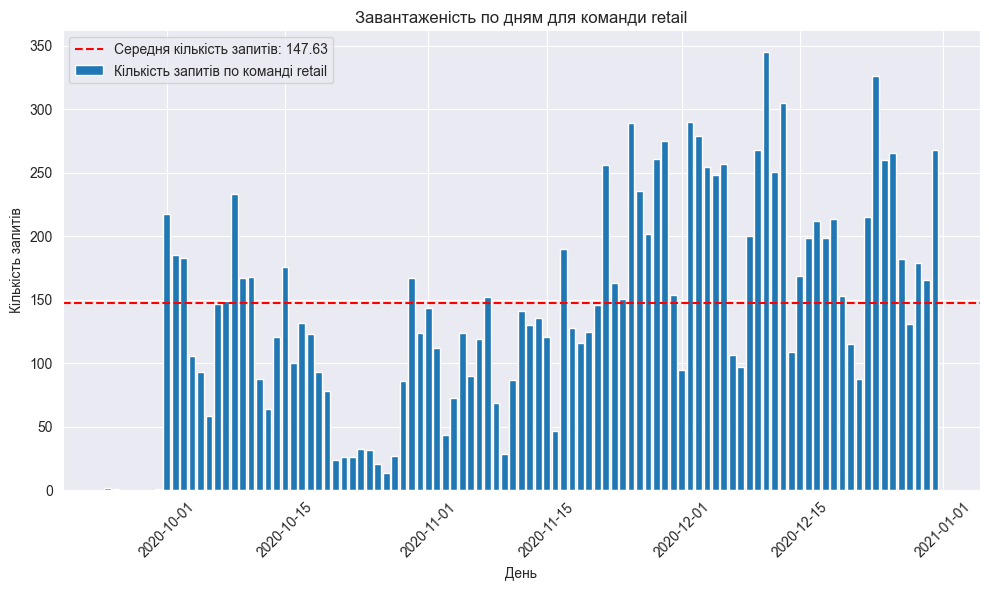

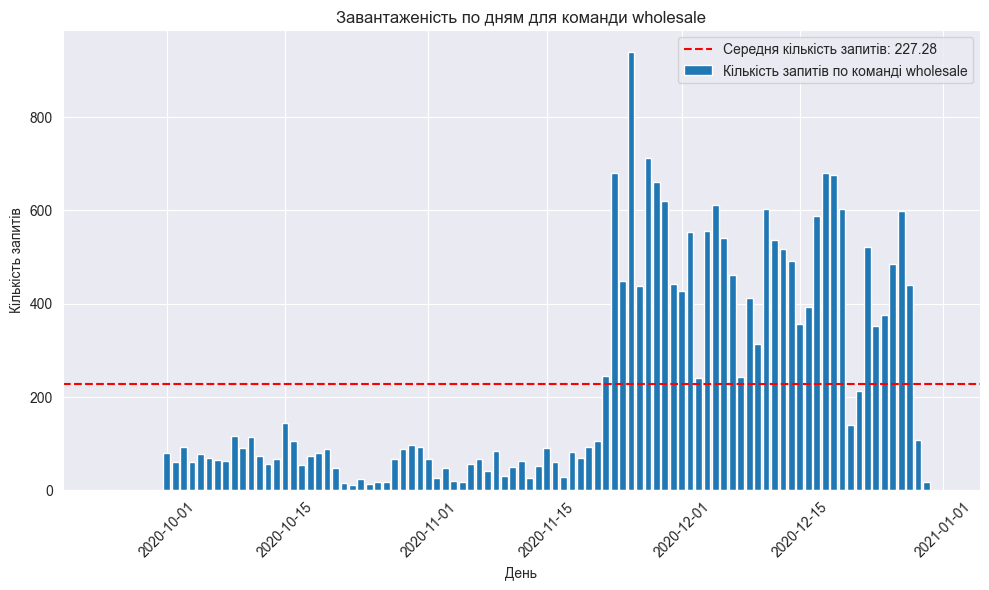

In [25]:

df['request_time'] = pd.to_datetime(df['request_time'])

df['day'] = df['request_time'].dt.date

daily_requests_by_team = df.groupby(['team', 'day']).size().unstack(fill_value=0)

# середня кількість запитів на день для кожної команди
avg_requests_by_team = daily_requests_by_team.mean(axis=1)

for team in daily_requests_by_team.index:
    plt.figure(figsize=(10, 6))

    plt.bar(daily_requests_by_team.columns, daily_requests_by_team.loc[team].values, label=f'Кількість запитів по команді {team}')

    # Лінія середньої кількості запитів по команді
    plt.axhline(avg_requests_by_team[team], color='red', linestyle='--', label=f'Середня кількість запитів: {avg_requests_by_team[team]:.2f}')

    plt.xlabel('День')
    plt.ylabel('Кількість запитів')
    plt.title(f'Завантаженість по дням для команди {team}')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


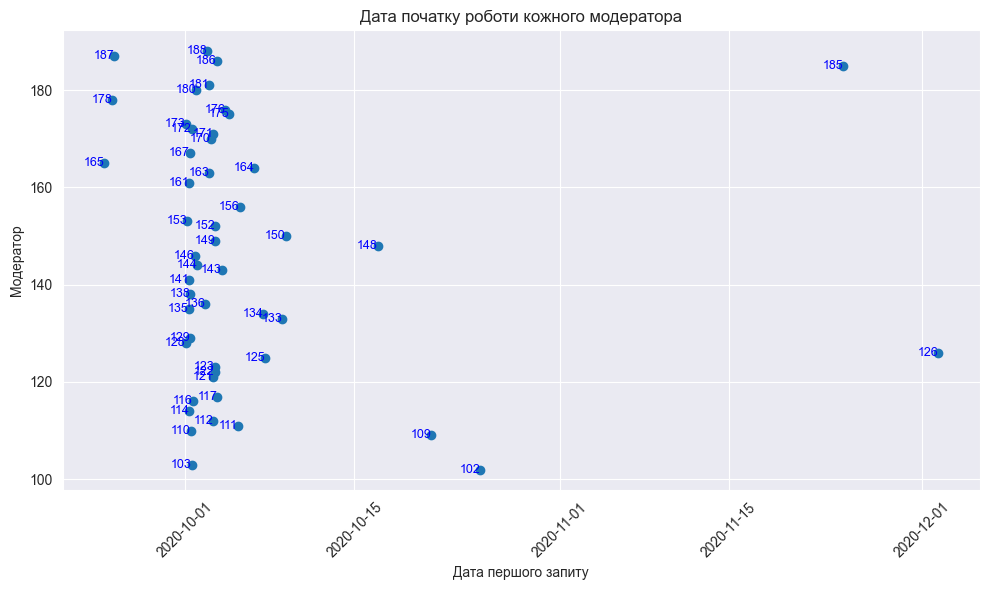

In [26]:
df['request_time'] = pd.to_datetime(df['request_time'])

first_requests = df.groupby('moderator')['request_time'].min().sort_values()

plt.figure(figsize=(10, 6))

# дати першого запиту по модераторах
plt.scatter(first_requests.values, first_requests.index)

for moderator, date in first_requests.items():
    plt.text(date, moderator, moderator, fontsize=9, ha='right', va='center', color='blue')

plt.xlabel('Дата першого запиту')
plt.ylabel('Модератор')
plt.title('Дата початку роботи кожного модератора')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


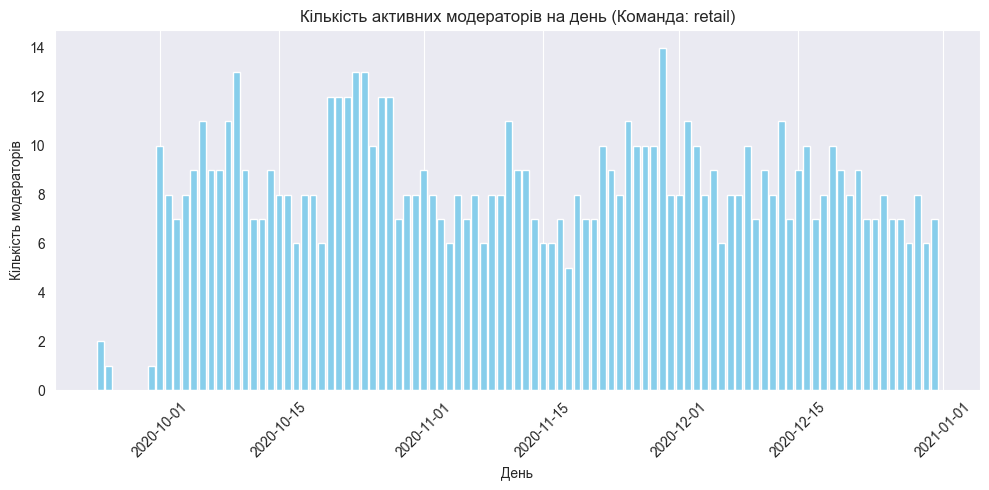

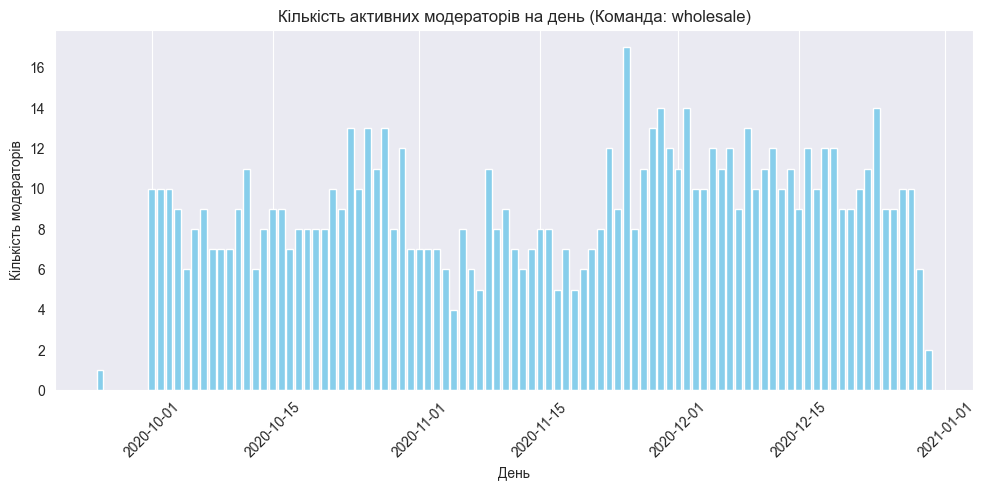

In [27]:
df['request_time'] = pd.to_datetime(df['request_time'])

df['day'] = df['request_time'].dt.date

grouped = df.groupby(['team', 'day'])['moderator'].nunique().reset_index(name='unique_moderators')

teams = grouped['team'].unique()

for team in teams:
    team_data = grouped[grouped['team'] == team]

    plt.figure(figsize=(10, 5))
    plt.bar(team_data['day'], team_data['unique_moderators'], color='skyblue')

    plt.title(f'Кількість активних модераторів на день (Команда: {team})')
    plt.xlabel('День')
    plt.ylabel('Кількість модераторів')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()


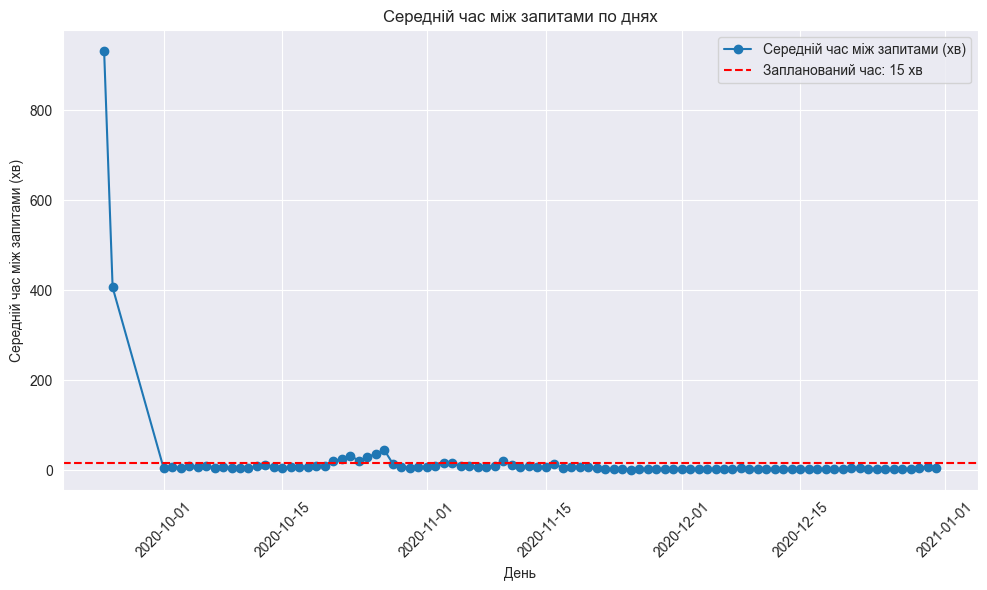

In [28]:
df['request_time'] = pd.to_datetime(df['request_time'])

df['day'] = df['request_time'].dt.date

df_sorted = df.sort_values(by=['day', 'request_time'])

df_sorted['time_diff'] = df_sorted.groupby('day')['request_time'].diff().dt.total_seconds() / 60

# середній час між запитами по кожному дню
avg_diff_per_day = df_sorted.groupby('day')['time_diff'].mean().dropna()

plt.figure(figsize=(10, 6))
plt.plot(avg_diff_per_day.index, avg_diff_per_day.values, marker='o', label='Середній час між запитами (хв)')

# Лінія на рівні 15 хв як запланований час
plt.axhline(y=15, color='red', linestyle='--', label='Запланований час: 15 хв')

plt.xlabel('День')
plt.ylabel('Середній час між запитами (хв)')
plt.title('Середній час між запитами по днях')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


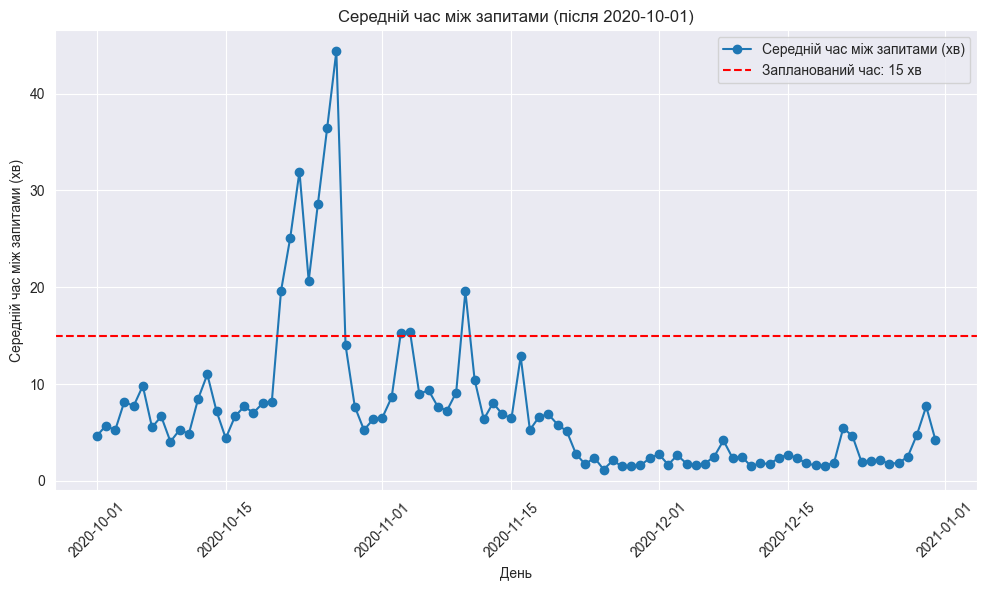

In [29]:
df['request_time'] = pd.to_datetime(df['request_time'])
df['day'] = df['request_time'].dt.date

# всі дні до 2020-10-01
filtered_df = df[df['day'] >= pd.to_datetime('2020-10-01').date()]


filtered_df = filtered_df.sort_values(by=['day', 'request_time'])

filtered_df['time_diff'] = filtered_df.groupby('day')['request_time'].diff().dt.total_seconds() / 60

avg_diff_per_day = filtered_df.groupby('day')['time_diff'].mean().dropna()

plt.figure(figsize=(10, 6))
plt.plot(avg_diff_per_day.index, avg_diff_per_day.values, marker='o', label='Середній час між запитами (хв)')
plt.axhline(y=15, color='red', linestyle='--', label='Запланований час: 15 хв')
plt.xlabel('День')
plt.ylabel('Середній час між запитами (хв)')
plt.title('Середній час між запитами (після 2020-10-01)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


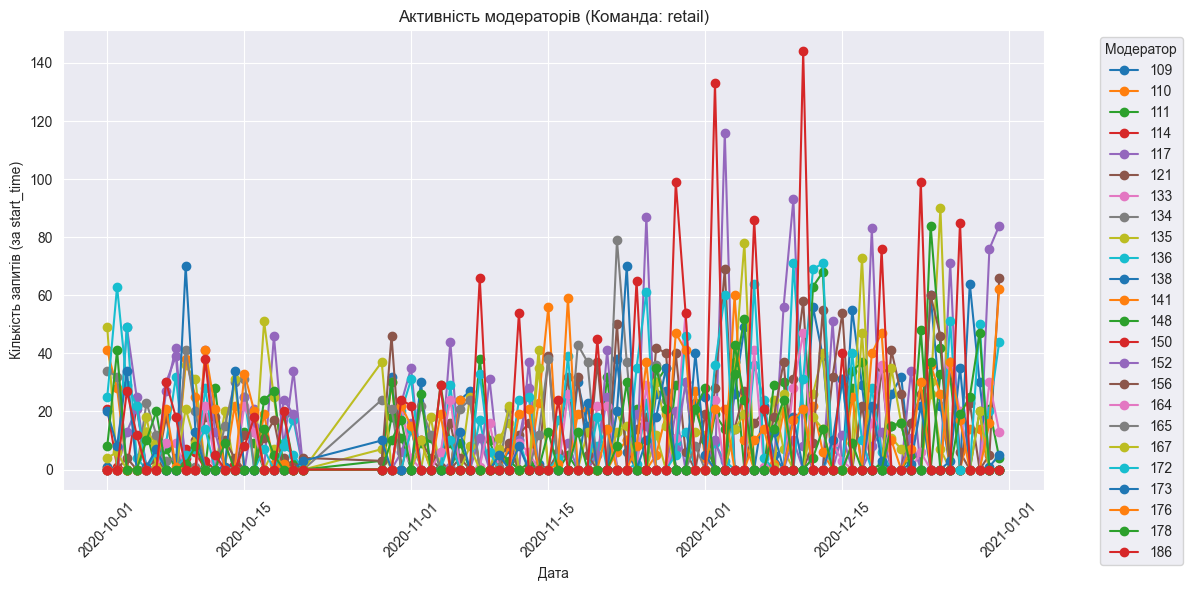

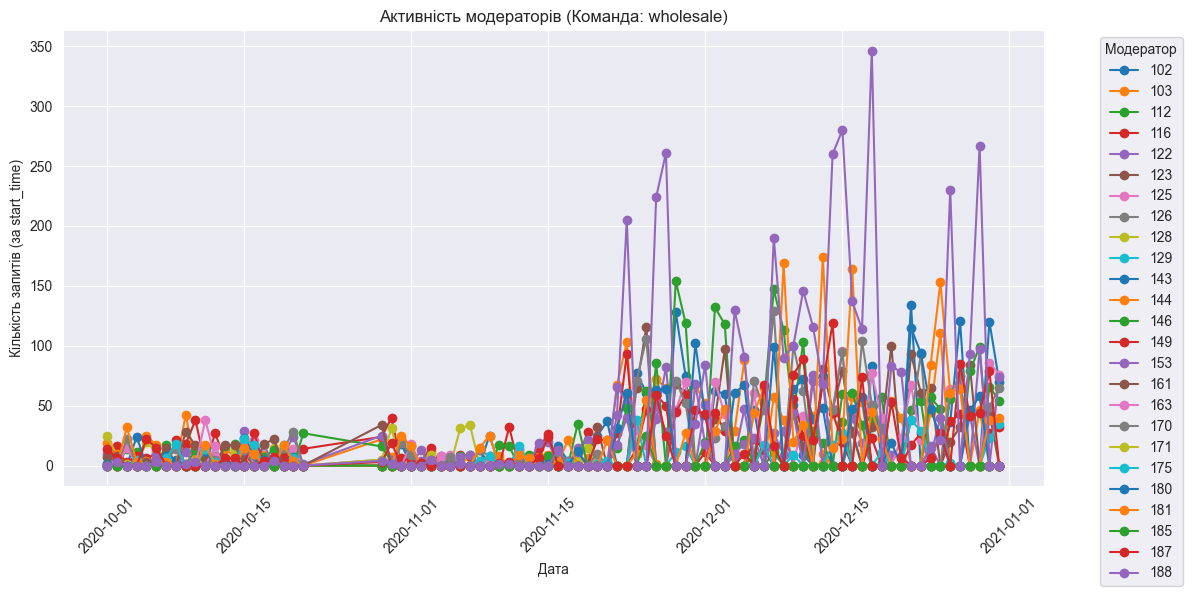

In [30]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date

# дні після 2020-10-01
filtered_df = df[df['day'] >= pd.to_datetime('2020-10-01').date()]

# Групуємо: команда, день, модератор → кількість запитів
grouped = filtered_df.groupby(['team', 'day', 'moderator']).size().reset_index(name='count')

teams = grouped['team'].unique()

for team in teams:
    team_data = grouped[grouped['team'] == team]
    pivot = team_data.pivot(index='day', columns='moderator', values='count').fillna(0)

    plt.figure(figsize=(12, 6))

    for moderator in pivot.columns:
        plt.plot(pivot.index, pivot[moderator], marker='o', label=str(moderator))

    plt.title(f'Активність модераторів (Команда: {team})')
    plt.xlabel('Дата')
    plt.ylabel('Кількість запитів (за start_time)')
    plt.xticks(rotation=45)
    plt.legend(title='Модератор', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [31]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date

filtered_df = df[df['day'] >= pd.to_datetime('2020-10-01').date()]

activity = filtered_df.groupby(['team', 'moderator']).size().reset_index(name='total_requests')

teams = activity['team'].unique()

for team in teams:
    team_activity = activity[activity['team'] == team]

    top_active = team_activity.sort_values(by='total_requests', ascending=False).head(5)
    top_inactive = team_activity.sort_values(by='total_requests', ascending=True).head(5)

    print(f"\n=== Команда: {team} ===")
    print("Топ 5 найактивніших модераторів:")
    print(top_active.to_string(index=False))

    print("\nТоп 5 найменш активних модераторів:")
    print(top_inactive.to_string(index=False))




=== Команда: retail ===
Топ 5 найактивніших модераторів:
  team  moderator  total_requests
retail        186            1342
retail        117            1251
retail        172             946
retail        135             857
retail        109             827

Топ 5 найменш активних модераторів:
  team  moderator  total_requests
retail        110               1
retail        138               1
retail        133               2
retail        134               8
retail        150              16

=== Команда: wholesale ===
Топ 5 найактивніших модераторів:
     team  moderator  total_requests
wholesale        188            3746
wholesale        112            1717
wholesale        170            1686
wholesale        181            1625
wholesale        123            1452

Топ 5 найменш активних модераторів:
     team  moderator  total_requests
wholesale        129               1
wholesale        171               1
wholesale        126               2
wholesale        185         

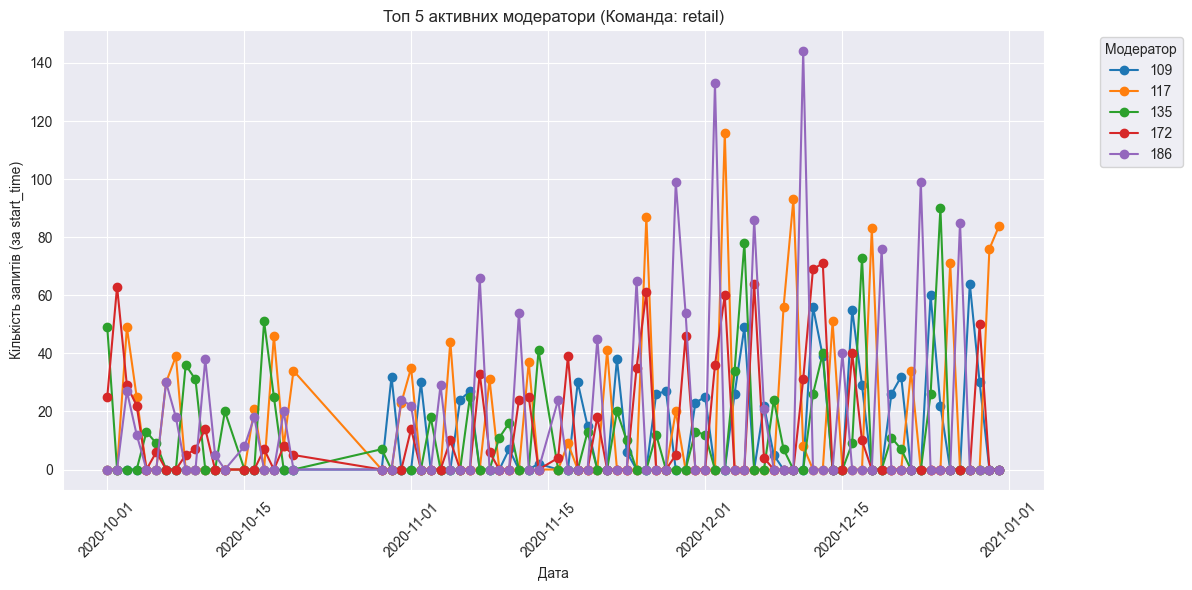

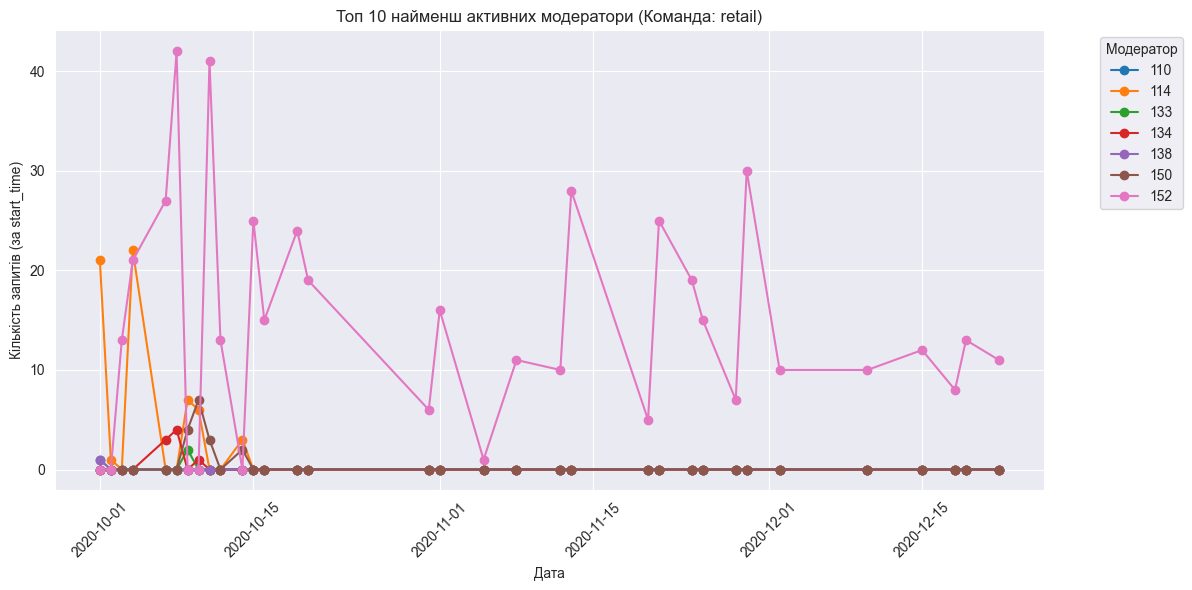

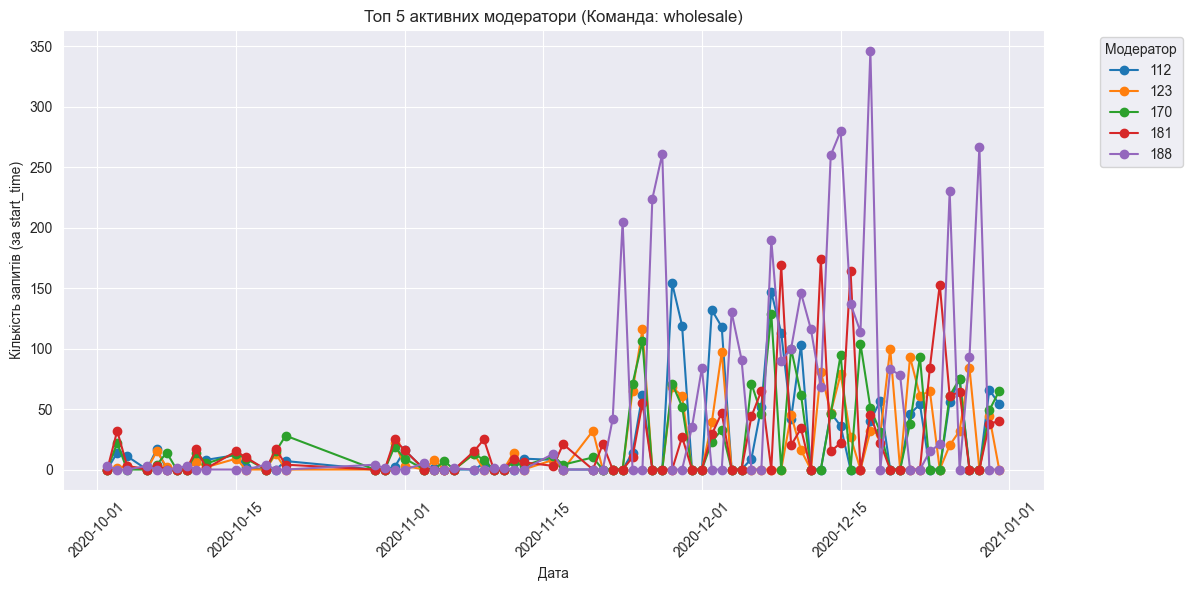

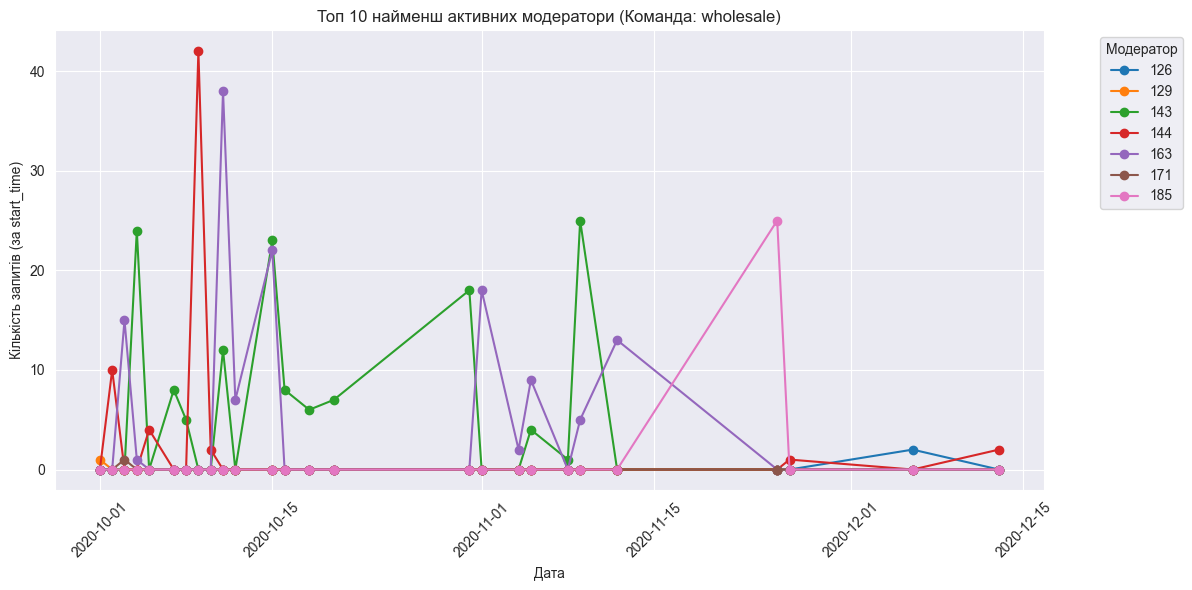

In [32]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date

filtered_df = df[df['day'] >= pd.to_datetime('2020-10-01').date()]

activity = filtered_df.groupby(['team', 'moderator']).size().reset_index(name='total_requests')

teams = activity['team'].unique()

for team in teams:
    team_activity = activity[activity['team'] == team]

    top_active = team_activity.sort_values(by='total_requests', ascending=False).head(5)['moderator']
    top_inactive = team_activity.sort_values(by='total_requests', ascending=True).head(7)['moderator']

    team_df = filtered_df[(filtered_df['team'] == team)]

    for group_name, group_moderators in {
        'Топ 5 активних': top_active,
        'Топ 10 найменш активних': top_inactive
    }.items():
        group_data = team_df[team_df['moderator'].isin(group_moderators)]

        grouped = group_data.groupby(['day', 'moderator']).size().reset_index(name='count')
        pivot = grouped.pivot(index='day', columns='moderator', values='count').fillna(0)

        plt.figure(figsize=(12, 6))
        for moderator in pivot.columns:
            plt.plot(pivot.index, pivot[moderator], marker='o', label=str(moderator))

        plt.title(f'{group_name} модератори (Команда: {team})')
        plt.xlabel('Дата')
        plt.ylabel('Кількість запитів (за start_time)')
        plt.xticks(rotation=45)
        plt.legend(title='Модератор', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [33]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date
filtered_df = df[df['day'] >= pd.to_datetime('2020-10-01').date()]

teams = filtered_df['team'].unique()

for team in teams:
    team_df = filtered_df[filtered_df['team'] == team]

    # загальна кількість обробок і першого дня роботи
    summary = team_df.groupby('moderator').agg(
        total_requests=('start_time', 'count'),
        first_start_date=('start_time', 'min')
    ).reset_index()

    summary = summary.sort_values(by='total_requests', ascending=True)

    print(f"\n=== Команда: {team} ===")
    print(summary.to_string(index=False))



=== Команда: retail ===
 moderator  total_requests    first_start_date
       110               1 2020-10-01 11:13:23
       138               1 2020-10-01 10:02:28
       133               2 2020-10-09 11:07:28
       134               8 2020-10-07 11:05:37
       150              16 2020-10-09 12:08:47
       114              60 2020-10-01 09:15:05
       152             477 2020-10-03 11:20:16
       167             536 2020-10-01 12:43:49
       111             569 2020-10-05 08:59:14
       173             613 2020-10-01 07:25:04
       178             630 2020-10-01 07:41:35
       164             640 2020-10-07 07:09:17
       165             698 2020-10-01 15:03:03
       141             713 2020-10-01 10:54:28
       148             741 2020-10-17 07:36:04
       136             747 2020-10-03 07:09:28
       156             748 2020-10-05 11:52:36
       121             799 2020-10-03 09:04:33
       176             803 2020-10-07 09:59:50
       109             827 2020-10-

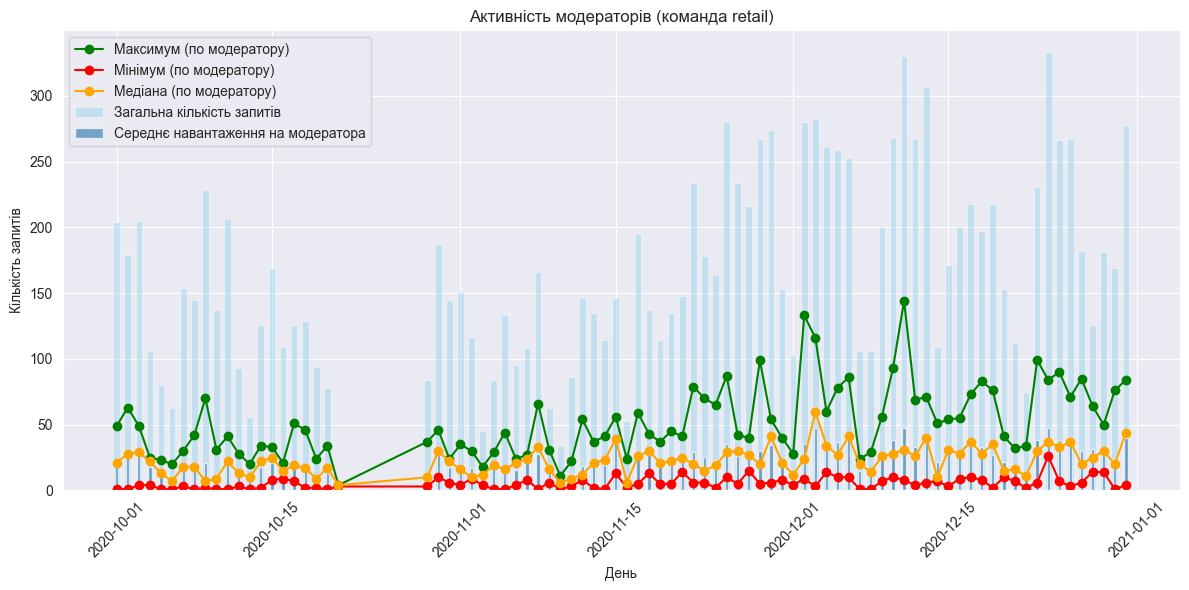

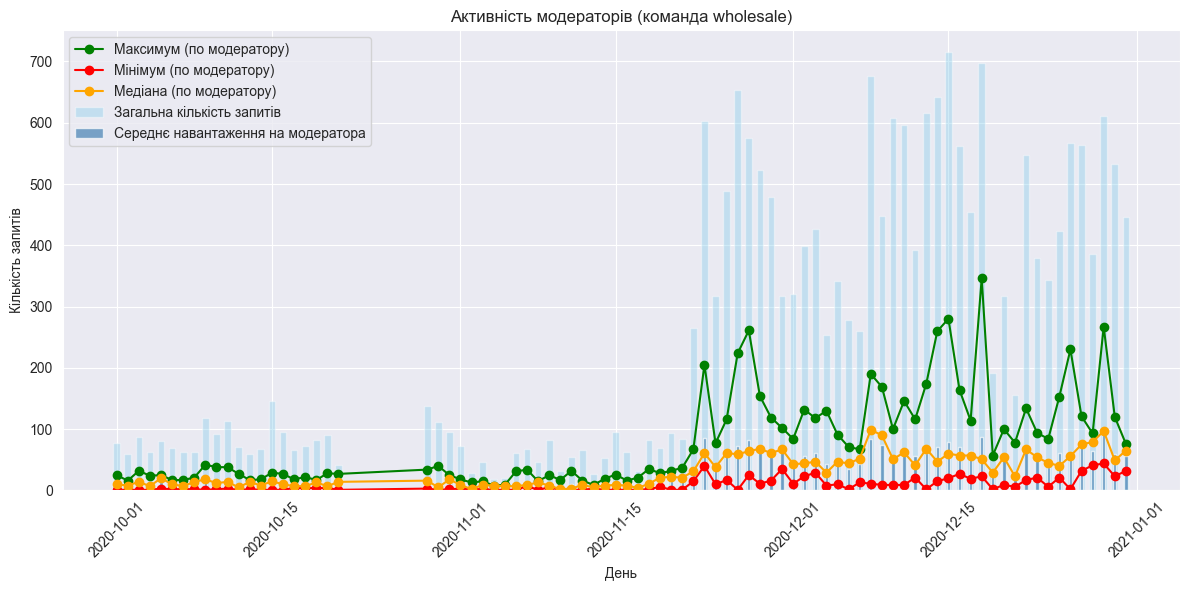

In [34]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["start_time"] = pd.to_datetime(df["start_time"])
df["day"] = df["start_time"].dt.date

# Загальна кількість запитів по днях
daily_total = df.groupby(["team", "day"]).agg(
    total_requests=("request_time", "count"),
    unique_moderators=("moderator", pd.Series.nunique)
).reset_index()

# Ідеальне навантаження
daily_total["ideal_per_mod"] = daily_total["total_requests"] / daily_total["unique_moderators"]

# Щоденна активність кожного модератора
daily_moderators = df.groupby(["team", "day", "moderator"]).size().reset_index(name="requests")


for team in df["team"].unique():
    team_total = daily_total[daily_total["team"] == team]
    team_mods = daily_moderators[daily_moderators["team"] == team]

    daily_stats = []
    for day in sorted(team_total["day"].unique()):
        mods_day = team_mods[team_mods["day"] == day].sort_values("requests")
        if mods_day.empty:
            continue
        top = mods_day.iloc[-1]["requests"]
        bottom = mods_day.iloc[0]["requests"]
        median = mods_day.iloc[len(mods_day) // 2]["requests"]
        daily_stats.append({
            "day": day,
            "top": top,
            "bottom": bottom,
            "median": median
        })

    daily_stats_df = pd.DataFrame(daily_stats)

    plt.figure(figsize=(12, 6))

    x = team_total["day"]

    plt.bar(x, team_total["total_requests"], width=0.6, label="Загальна кількість запитів", alpha=0.4, color='skyblue')

    plt.bar(x, team_total["ideal_per_mod"], width=0.3, label="Середнє навантаження на модератора", alpha=0.7, color='steelblue')

    plt.plot(daily_stats_df["day"], daily_stats_df["top"], color='green', marker='o', label="Максимум (по модератору)")
    plt.plot(daily_stats_df["day"], daily_stats_df["bottom"], color='red', marker='o', label="Мінімум (по модератору)")
    plt.plot(daily_stats_df["day"], daily_stats_df["median"], color='orange', marker='o', label="Медіана (по модератору)")

    plt.xlabel("День")
    plt.ylabel("Кількість запитів")
    plt.title(f"Активність модераторів (команда {team})")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



Команда retail:
    hour  requests  finished
0      0        78         0
1      1        31         0
2      2        29         0
3      3        63         0
4      4       109         0
5      5       271         0
6      6       420         0
7      7       741      1457
8      8       937       578
9      9      1194      1411
10    10      1159       701
11    11      1391      1589
12    12      1154       870
13    13      1154      1819
14    14       913       793
15    15       781       911
16    16       567       661
17    17       605       713
18    18       600       488
19    19       629       798
20    20       518       562
21    21       323       472
22    22       221       201
23    23       137         1


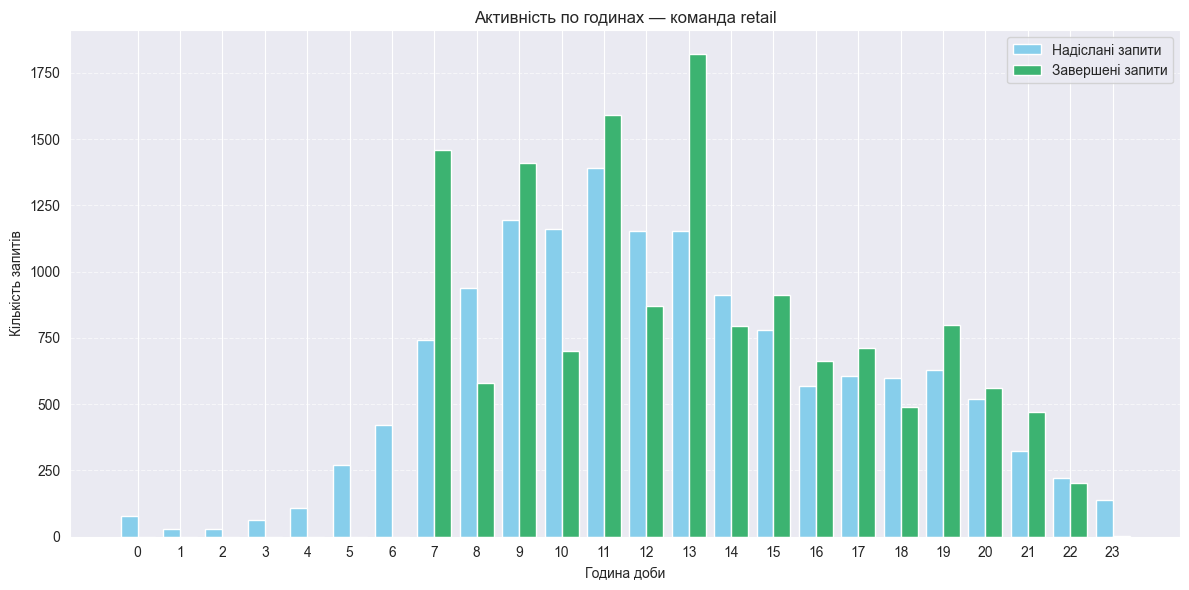


Команда wholesale:
    hour  requests  finished
0      0       509         7
1      1      1476         0
2      2      1789         0
3      3      1847         0
4      4       949         0
5      5      1179         0
6      6      1619         0
7      7      1831      1916
8      8      2449      2386
9      9      1746      2024
10    10       856      2260
11    11       778      1804
12    12       771      1797
13    13       840      1112
14    14       827      1391
15    15       729       932
16    16       422      1167
17    17       167       957
18    18        97      1036
19    19        92       670
20    20       145       885
21    21       126       522
22    22       133       711
23    23       215        15


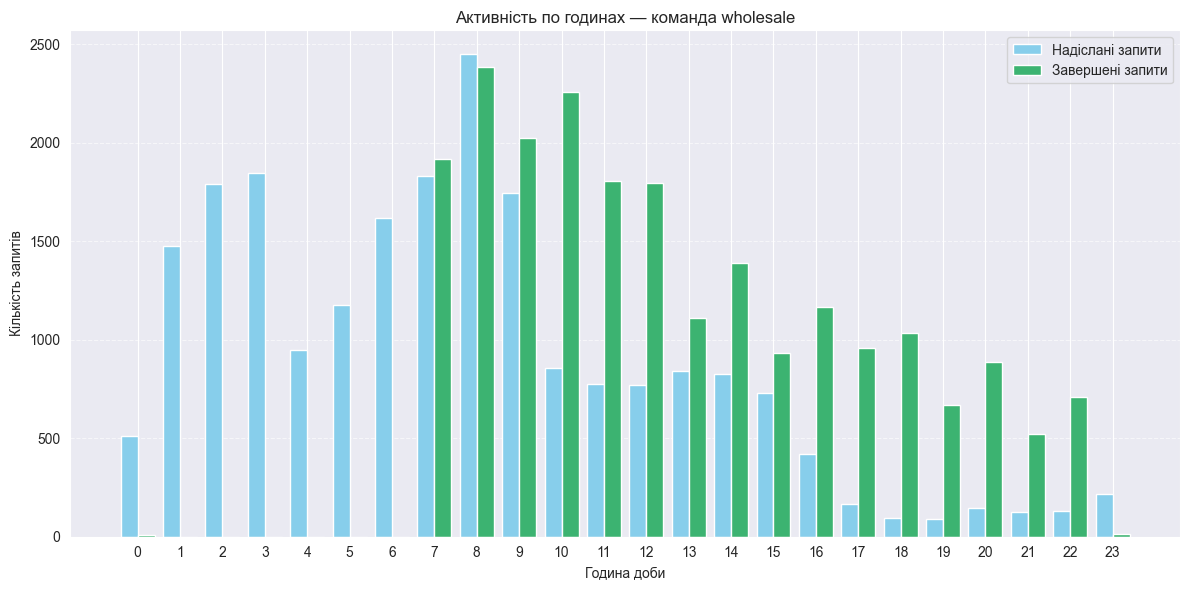

In [35]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])
df["team"] = df["team"].astype(str)  # на всяк випадок

df["request_hour"] = df["request_time"].dt.hour
df["finish_hour"] = df["finish_time"].dt.hour

teams = df["team"].unique()

for team in teams:
    team_df = df[df["team"] == team]

    request_counts = team_df.groupby("request_hour").size().reset_index(name="requests")
    finish_counts = team_df.groupby("finish_hour").size().reset_index(name="finished")

    hourly = pd.DataFrame({"hour": range(24)})
    hourly = hourly.merge(request_counts, left_on="hour", right_on="request_hour", how="left").drop(columns=["request_hour"])
    hourly = hourly.merge(finish_counts, left_on="hour", right_on="finish_hour", how="left").drop(columns=["finish_hour"])
    hourly = hourly.fillna(0)

    print(f"\nКоманда {team}:")
    print(hourly.astype(int))

    plt.figure(figsize=(12, 6))
    plt.bar(hourly["hour"] - 0.2, hourly["requests"], width=0.4, label="Надіслані запити", color='skyblue')
    plt.bar(hourly["hour"] + 0.2, hourly["finished"], width=0.4, label="Завершені запити", color='mediumseagreen')

    plt.title(f"Активність по годинах — команда {team}")
    plt.xlabel("Година доби")
    plt.ylabel("Кількість запитів")
    plt.xticks(range(24))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()



 Загальна активність по годинах:
    hour  requests  finished
0      0       587         7
1      1      1507         0
2      2      1818         0
3      3      1910         0
4      4      1058         0
5      5      1450         0
6      6      2039         0
7      7      2572      3373
8      8      3386      2964
9      9      2940      3435
10    10      2015      2961
11    11      2169      3393
12    12      1925      2667
13    13      1994      2931
14    14      1740      2184
15    15      1510      1843
16    16       989      1828
17    17       772      1670
18    18       697      1524
19    19       721      1468
20    20       663      1447
21    21       449       994
22    22       354       912
23    23       352        16


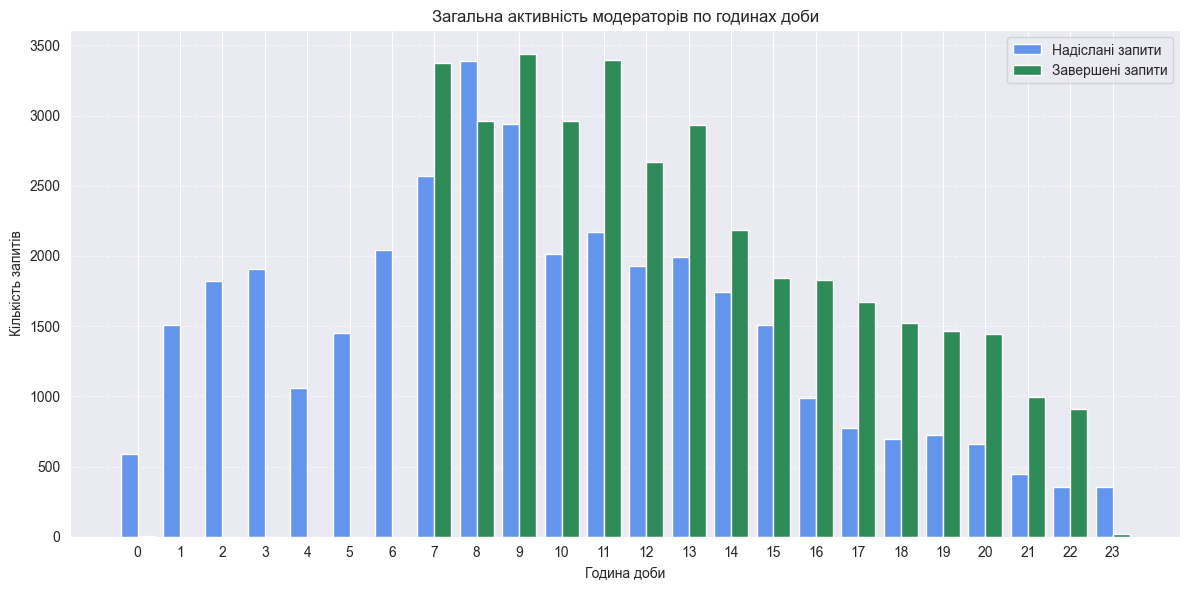

In [36]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])

df["request_hour"] = df["request_time"].dt.hour
df["finish_hour"] = df["finish_time"].dt.hour

request_counts = df.groupby("request_hour").size().reset_index(name="requests")
finish_counts = df.groupby("finish_hour").size().reset_index(name="finished")


hourly = pd.DataFrame({"hour": range(24)})
hourly = hourly.merge(request_counts, left_on="hour", right_on="request_hour", how="left").drop(columns=["request_hour"])
hourly = hourly.merge(finish_counts, left_on="hour", right_on="finish_hour", how="left").drop(columns=["finish_hour"])
hourly = hourly.fillna(0)

print(" Загальна активність по годинах:")
print(hourly.astype(int))


plt.figure(figsize=(12, 6))
plt.bar(hourly["hour"] - 0.2, hourly["requests"], width=0.4, label="Надіслані запити", color='cornflowerblue')
plt.bar(hourly["hour"] + 0.2, hourly["finished"], width=0.4, label="Завершені запити", color='seagreen')

plt.title("Загальна активність модераторів по годинах доби")
plt.xlabel("Година доби")
plt.ylabel("Кількість запитів")
plt.xticks(range(24))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


📊 Середня затримка відповіді по годинах (в хвилинах):
    request_hour  avg_response_delay_min
0              0             2989.233135
1              1             3547.540798
2              2             3761.238586
3              3             3470.862417
4              4             3250.169928
5              5             3474.176460
6              6             3090.848807
7              7             2716.944537
8              8             3080.752048
9              9             2763.945646
10            10             2086.305070
11            11             1599.428577
12            12             1685.767662
13            13             1823.790296
14            14             1742.759943
15            15             2072.166556
16            16             1648.962572
17            17             1213.603584
18            18              962.169440
19            19              635.643574
20            20              951.492911
21            21             1569.694878
22 

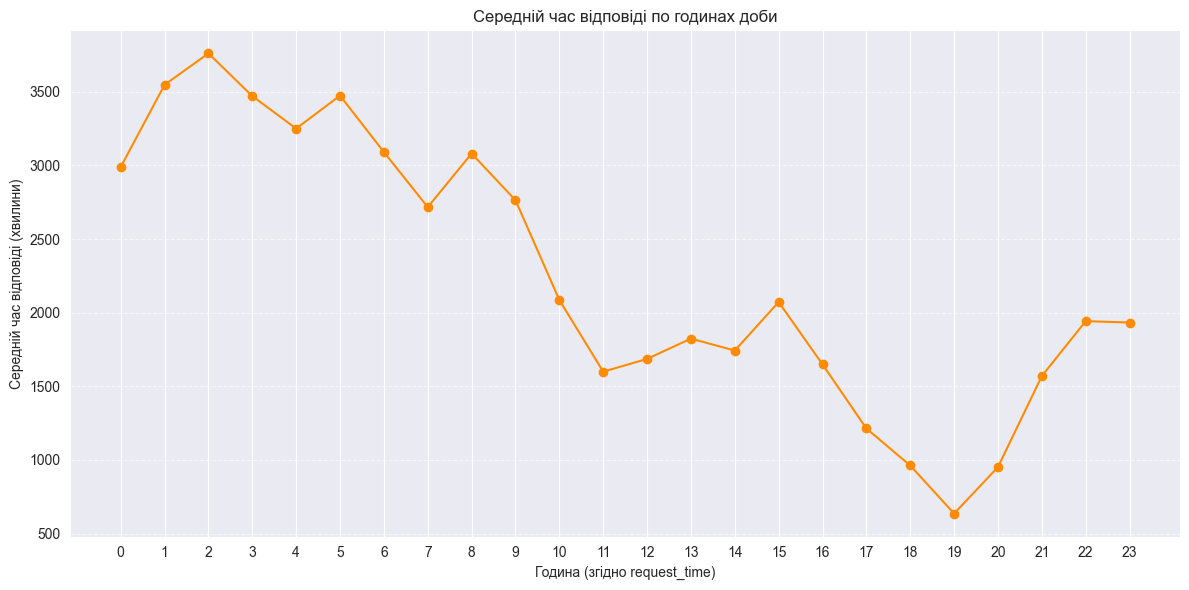

In [37]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])

df["response_delay_min"] = (df["finish_time"] - df["request_time"]).dt.total_seconds() / 60


df["request_hour"] = df["request_time"].dt.hour


hourly_delay = (
    df.groupby("request_hour")["response_delay_min"]
    .mean()
    .reset_index(name="avg_response_delay_min")
)


print(" Середня затримка відповіді по годинах (в хвилинах):")
print(hourly_delay)

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.plot(hourly_delay["request_hour"], hourly_delay["avg_response_delay_min"],
         marker='o', linestyle='-', color='darkorange')
plt.title("Середній час відповіді по годинах доби")
plt.xlabel("Година (згідно request_time)")
plt.ylabel("Середній час відповіді (хвилини)")
plt.xticks(range(24))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


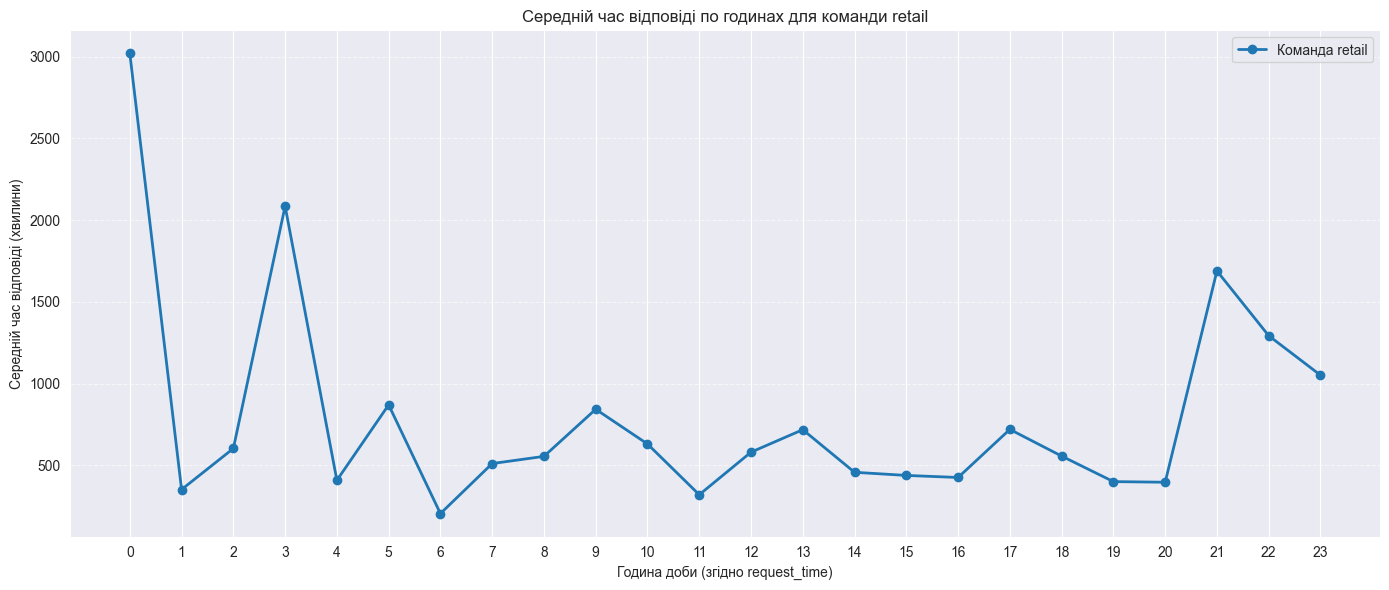

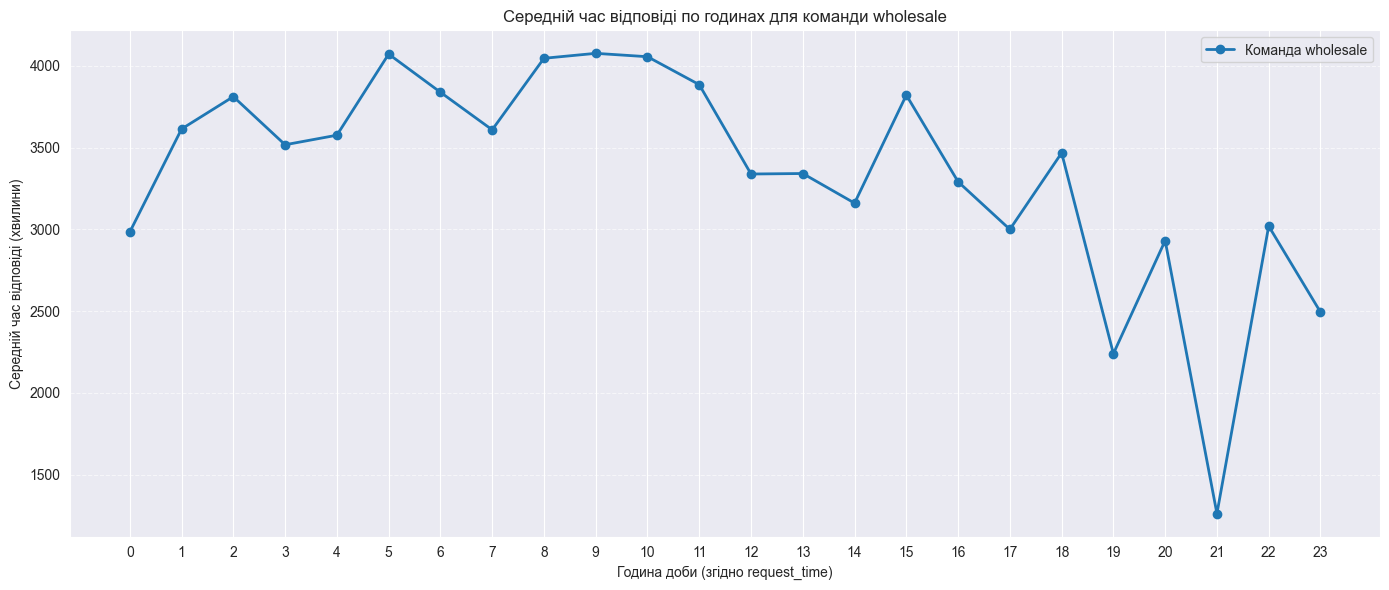


Таблиця для команди retail:
      team  moderator  total_requests  avg_response_delay  avg_request_hour
6   retail        133               2          449.716667               4.0
13  retail        150              16          121.619792               7.0
7   retail        134               8            1.920833               9.0
2   retail        111             569          544.650117              10.0
3   retail        114              60           75.659722              10.0
10  retail        138               1            0.333333              10.0
15  retail        156             748         1265.372839              10.0
16  retail        164             640          730.032812              10.0
19  retail        172             946          592.924771              10.0
1   retail        110               1            8.433333              11.0
5   retail        121             799          692.007030              11.0
8   retail        135             857          443.133567  

In [38]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])

df["response_delay_min"] = (df["finish_time"] - df["request_time"]).dt.total_seconds() / 60

df["request_hour"] = df["request_time"].dt.hour

# середння затримка для кожної команди по годинах
hourly_delay_by_team = (
    df.groupby(["team", "request_hour"])["response_delay_min"]
    .mean()
    .reset_index(name="avg_response_delay_min")
)

hourly_delay_by_team = hourly_delay_by_team.sort_values(by=["request_hour"])


teams = hourly_delay_by_team["team"].unique()

for team in teams:
    plt.figure(figsize=(14, 6))
    team_data = hourly_delay_by_team[hourly_delay_by_team["team"] == team]

    plt.plot(team_data["request_hour"], team_data["avg_response_delay_min"],
             marker='o', linestyle='-', linewidth=2, label=f"Команда {team}")

    plt.title(f"Середній час відповіді по годинах для команди {team}")
    plt.xlabel("Година доби (згідно request_time)")
    plt.ylabel("Середній час відповіді (хвилини)")
    plt.xticks(range(24))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


team_mod_stats = df.groupby(["team", "moderator"]).agg(
    total_requests=("request_time", "count"),
    avg_response_delay=("response_delay_min", "mean"),
    avg_request_hour=("request_hour", "mean")
).reset_index()


team_mod_stats["avg_request_hour"] = team_mod_stats["avg_request_hour"].round()
team_mod_stats = team_mod_stats.sort_values(by=["team", "avg_request_hour"])


teams = df["team"].unique()

for team in teams:
    print(f"\nТаблиця для команди {team}:")
    team_data = team_mod_stats[team_mod_stats["team"] == team]
    print(team_data)


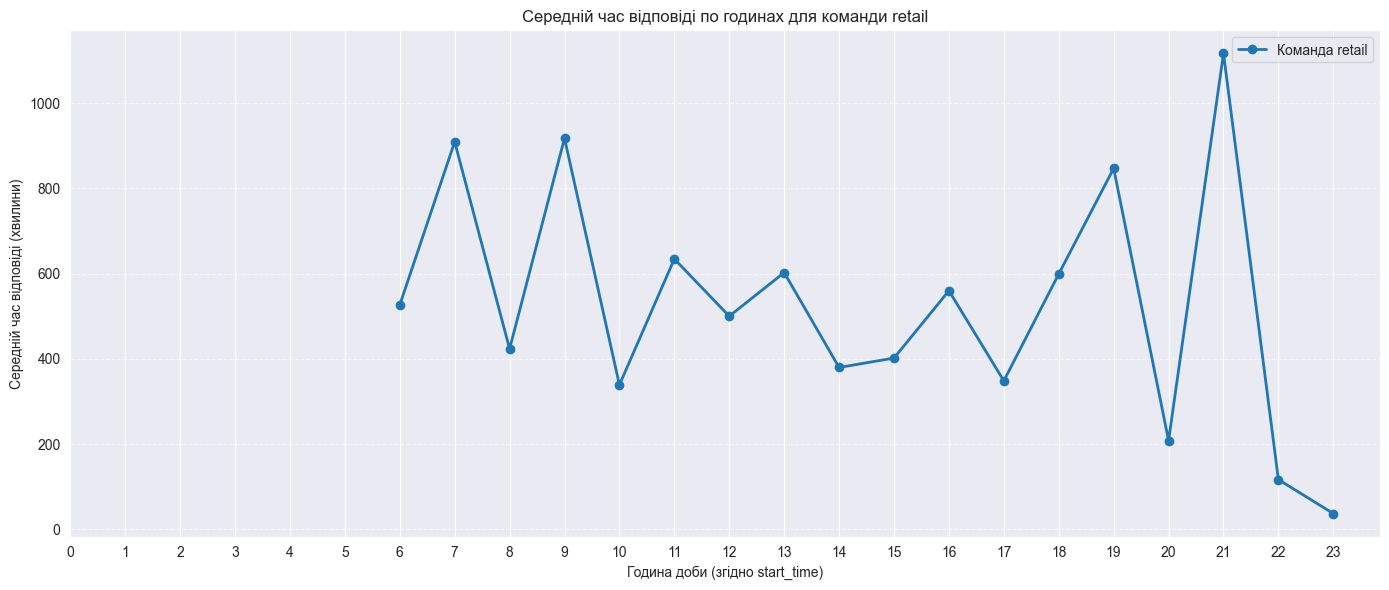

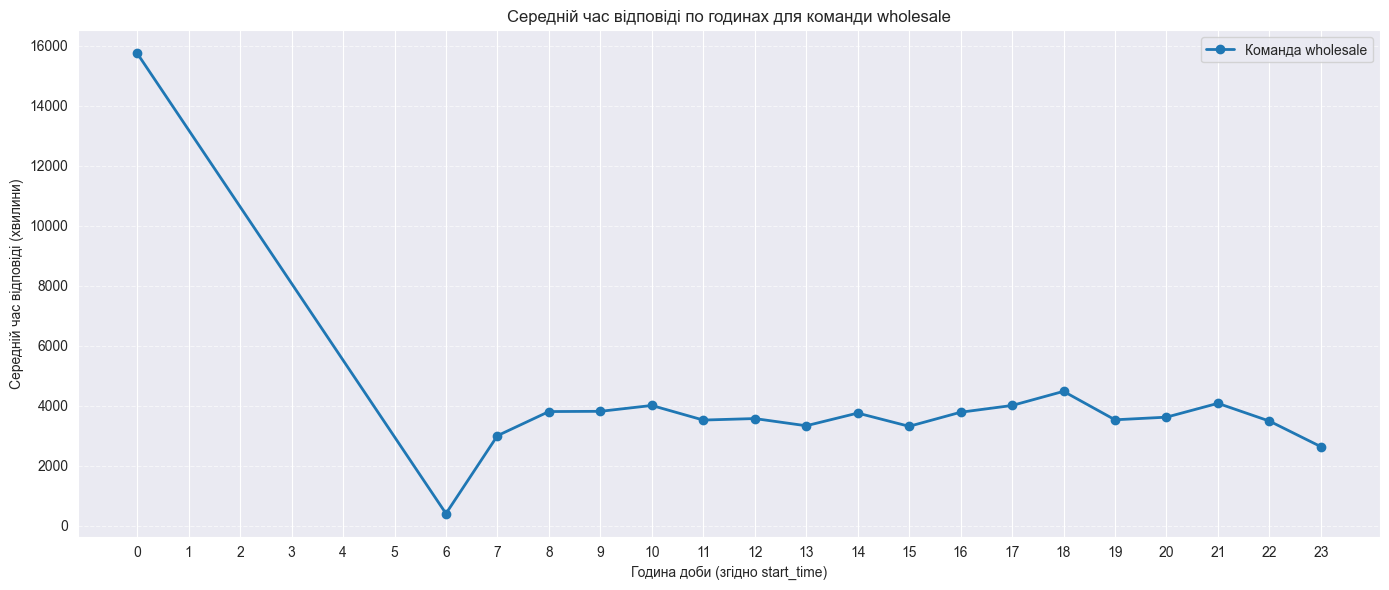


Таблиця для команди retail:
      team  moderator  total_requests  avg_response_delay  avg_start_hour
7   retail        134               8            1.920833        8.875000
13  retail        150              16          121.619792        9.250000
2   retail        111             569          544.650117        9.736380
10  retail        138               1            0.333333       10.000000
20  retail        173             613          593.816857       10.078303
11  retail        141             713          652.346611       10.318373
16  retail        164             640          730.032812       10.362500
22  retail        178             630          389.546772       10.476190
19  retail        172             946          592.924771       10.534884
9   retail        136             747          632.474922       10.769746
15  retail        156             748         1265.372839       10.823529
14  retail        152             477          587.886513       10.865828
3   retai

In [39]:
df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])
df["start_time"] = pd.to_datetime(df["start_time"])

df["response_delay_min"] = (df["finish_time"] - df["request_time"]).dt.total_seconds() / 60

df["start_hour"] = df["start_time"].dt.hour

hourly_delay_by_team = (
    df.groupby(["team", "start_hour"])["response_delay_min"]
    .mean()
    .reset_index(name="avg_response_delay_min")
)

teams = hourly_delay_by_team["team"].unique()

for team in teams:
    plt.figure(figsize=(14, 6))
    team_data = hourly_delay_by_team[hourly_delay_by_team["team"] == team]

    plt.plot(team_data["start_hour"], team_data["avg_response_delay_min"],
             marker='o', linestyle='-', linewidth=2, label=f"Команда {team}")

    plt.title(f"Середній час відповіді по годинах для команди {team}")
    plt.xlabel("Година доби (згідно start_time)")
    plt.ylabel("Середній час відповіді (хвилини)")
    plt.xticks(range(24))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

df["request_time"] = pd.to_datetime(df["request_time"])
df["finish_time"] = pd.to_datetime(df["finish_time"])
df["start_time"] = pd.to_datetime(df["start_time"])

df["response_delay_min"] = (df["finish_time"] - df["request_time"]).dt.total_seconds() / 60

df["start_hour"] = df["start_time"].dt.hour

team_mod_stats = df.groupby(["team", "moderator"]).agg(
    total_requests=("request_time", "count"),
    avg_response_delay=("response_delay_min", "mean"),
    avg_start_hour=("start_hour", "mean")
).reset_index()


team_mod_stats = team_mod_stats.sort_values(by=["team", "avg_start_hour"])

teams = df["team"].unique()

for team in teams:
    print(f"\nТаблиця для команди {team}:")
    team_data = team_mod_stats[team_mod_stats["team"] == team]
    print(team_data)


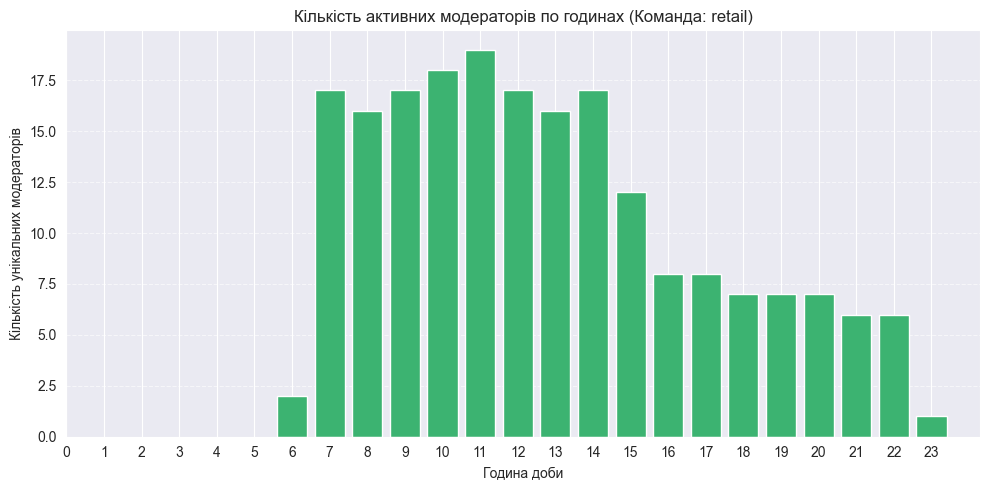

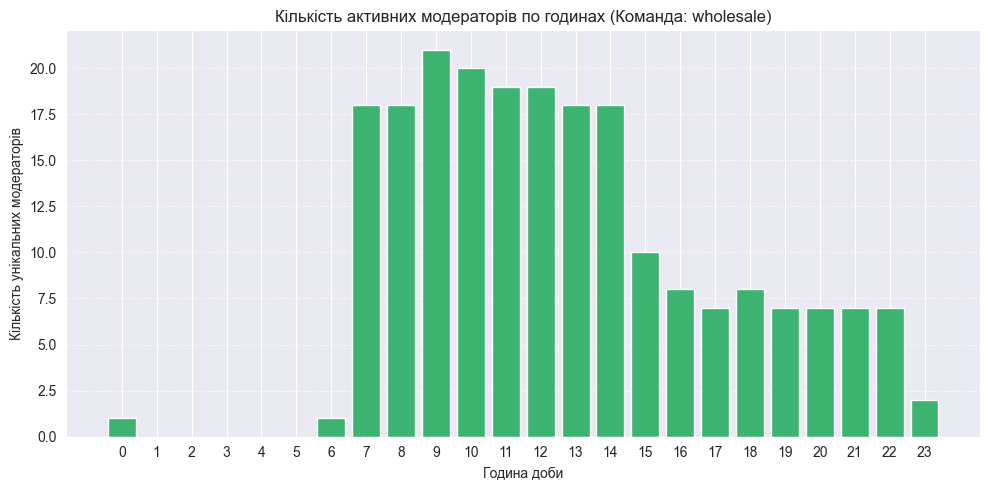

In [63]:
df['start_time'] = pd.to_datetime(df['start_time'])

df['hour'] = df['start_time'].dt.hour

grouped = df.groupby(['team', 'hour'])['moderator'].nunique().reset_index(name='unique_moderators')

teams = grouped['team'].unique()

for team in teams:
    team_data = grouped[grouped['team'] == team]

    plt.figure(figsize=(10, 5))
    plt.bar(team_data['hour'], team_data['unique_moderators'], color='mediumseagreen')

    plt.title(f'Кількість активних модераторів по годинах (Команда: {team})')
    plt.xlabel('Година доби')
    plt.ylabel('Кількість унікальних модераторів')
    plt.xticks(range(24))
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


C:\Users\Юля\AppData\Local\Temp\ipykernel_5452\3394803722.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='moderator', y='total_requests', data=moderator_requests, palette="Blues_d")


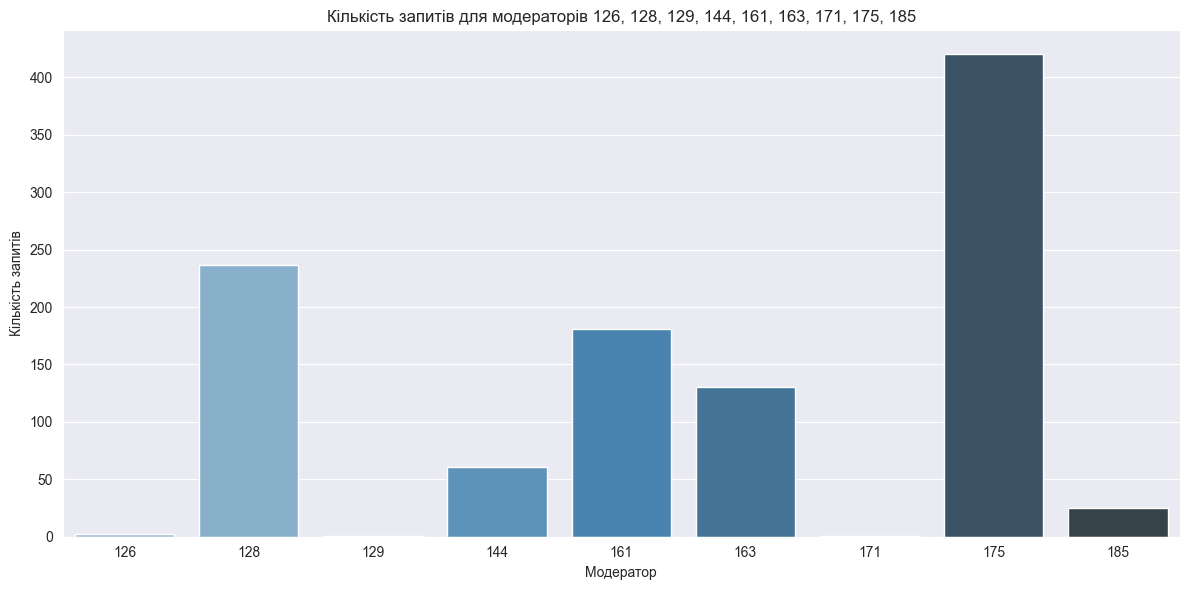

In [57]:
# Список модераторів, для яких потрібно вивести кількість запитів
moderators_list = [126, 128, 129, 144, 161, 163, 171, 175, 185]

filtered_moderators = df[df['moderator'].isin(moderators_list)]

moderator_requests = filtered_moderators.groupby('moderator').size().reset_index(name='total_requests')

plt.figure(figsize=(12, 6))
sns.barplot(x='moderator', y='total_requests', data=moderator_requests, palette="Blues_d")

plt.title('Кількість запитів для модераторів 126, 128, 129, 144, 161, 163, 171, 175, 185')
plt.xlabel('Модератор')
plt.ylabel('Кількість запитів')
plt.tight_layout()


plt.show()


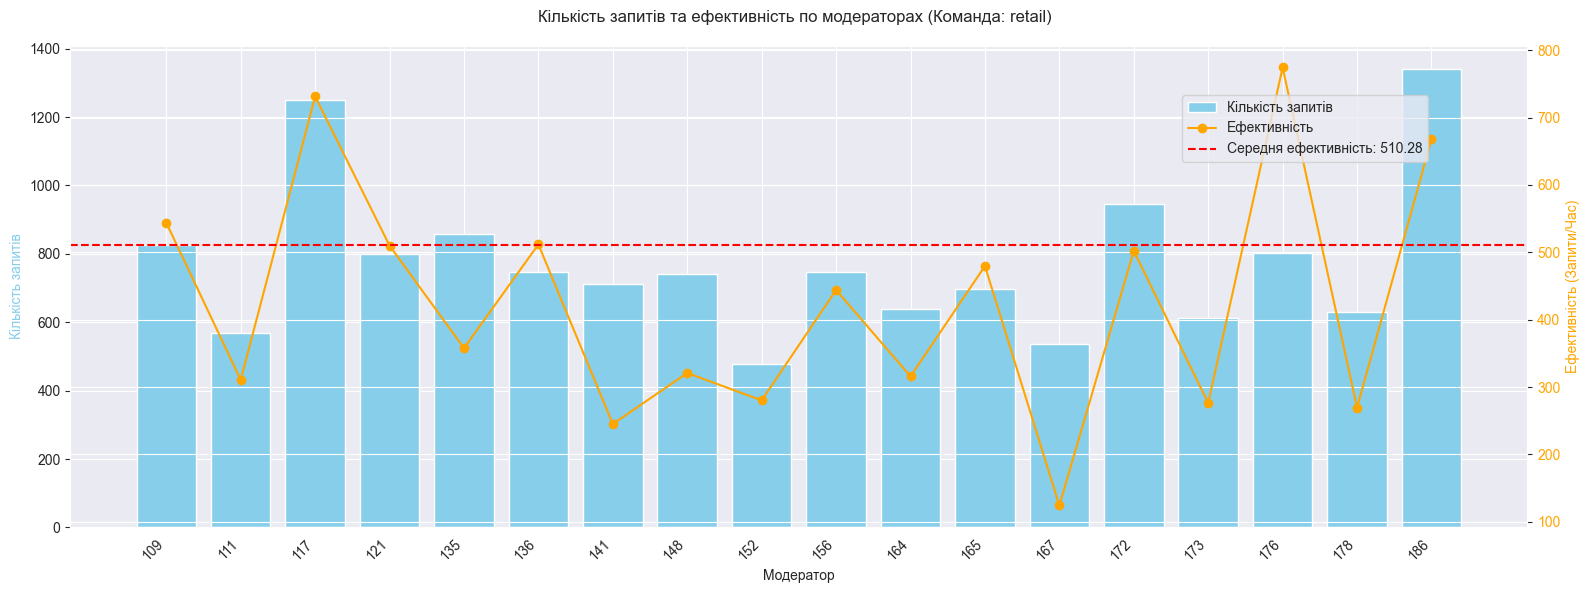

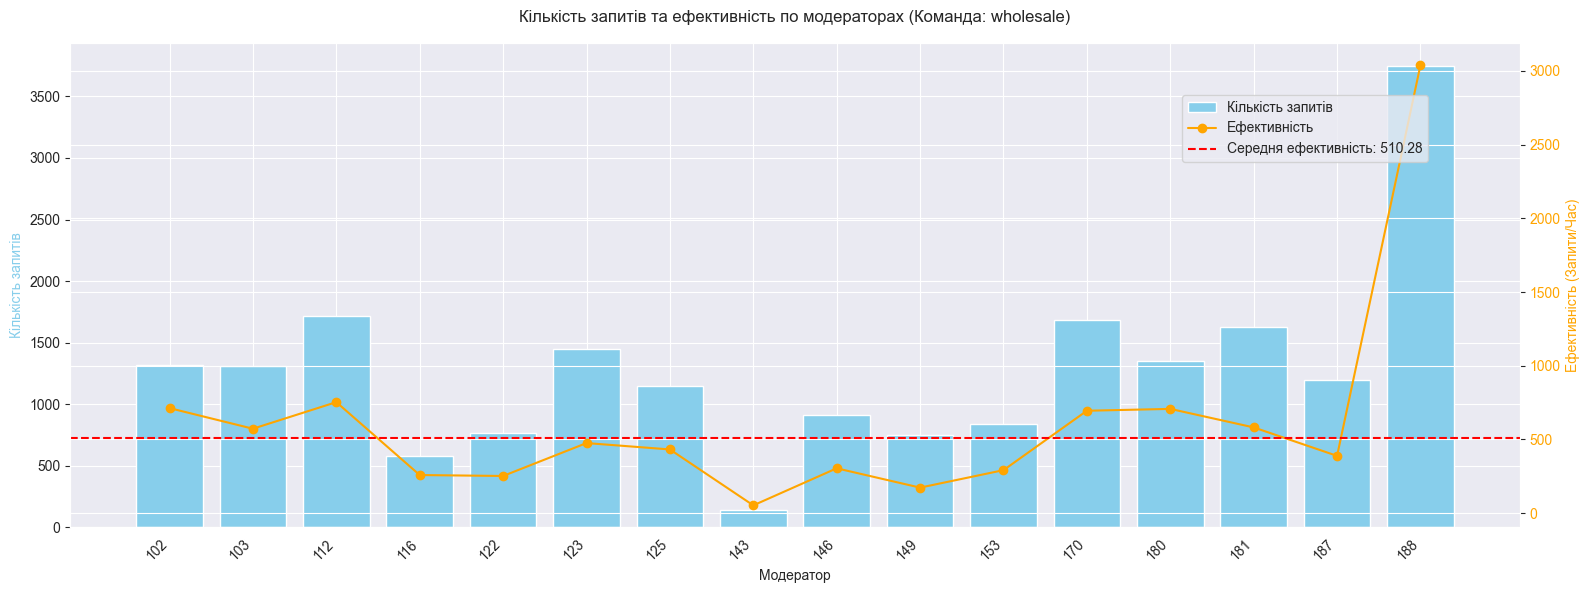

In [62]:
moderator_summary = df.groupby(['team', 'moderator']).agg(
    first_request=('request_date', 'min'),
    total_requests=('moderator', 'count'),
    avg_handling_time=('handling_time', 'mean')
).reset_index()

# Модератори, яких треба виключити
excluded_moderators = [126, 128, 129, 144, 161, 163, 171, 175, 185, 110, 114, 133, 134, 138, 150]

filtered_summary = moderator_summary[~moderator_summary['moderator'].isin(excluded_moderators)].copy()

# індекс ефективності
filtered_summary['efficiency'] = filtered_summary['total_requests'] / filtered_summary['avg_handling_time']

# Середнє значення ефективності без виключених
average_efficiency = filtered_summary['efficiency'].mean()

teams = filtered_summary['team'].unique()

for team in teams:
    team_data = filtered_summary[filtered_summary['team'] == team]
    moderators = team_data['moderator'].tolist()
    x = np.arange(len(moderators))

    fig, ax1 = plt.subplots(figsize=(16, 6))

    ax1.bar(x, team_data["total_requests"], color="skyblue", label="Кількість запитів")
    ax1.set_ylabel("Кількість запитів", color="skyblue")
    ax1.set_xlabel("Модератор")
    ax1.set_xticks(x)
    ax1.set_xticklabels(moderators, rotation=45, ha="right")

    ax2 = ax1.twinx()
    ax2.plot(x, team_data["efficiency"], label="Ефективність", color="orange", marker='o')
    ax2.set_ylabel("Ефективність (Запити/Час)", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    ax2.axhline(y=average_efficiency, color="red", linestyle='--', label=f"Середня ефективність: {average_efficiency:.2f}")

    fig.suptitle(f"Кількість запитів та ефективність по модераторах (Команда: {team})")
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

    plt.tight_layout()
    plt.show()


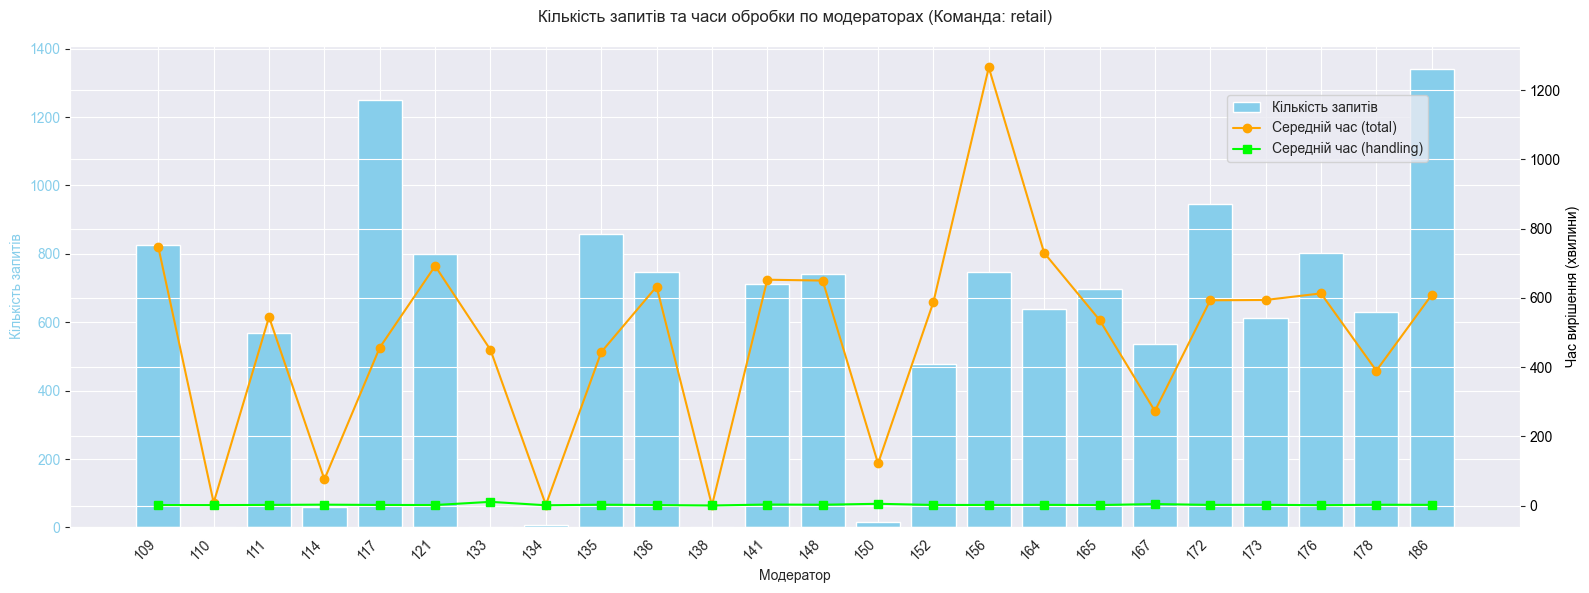

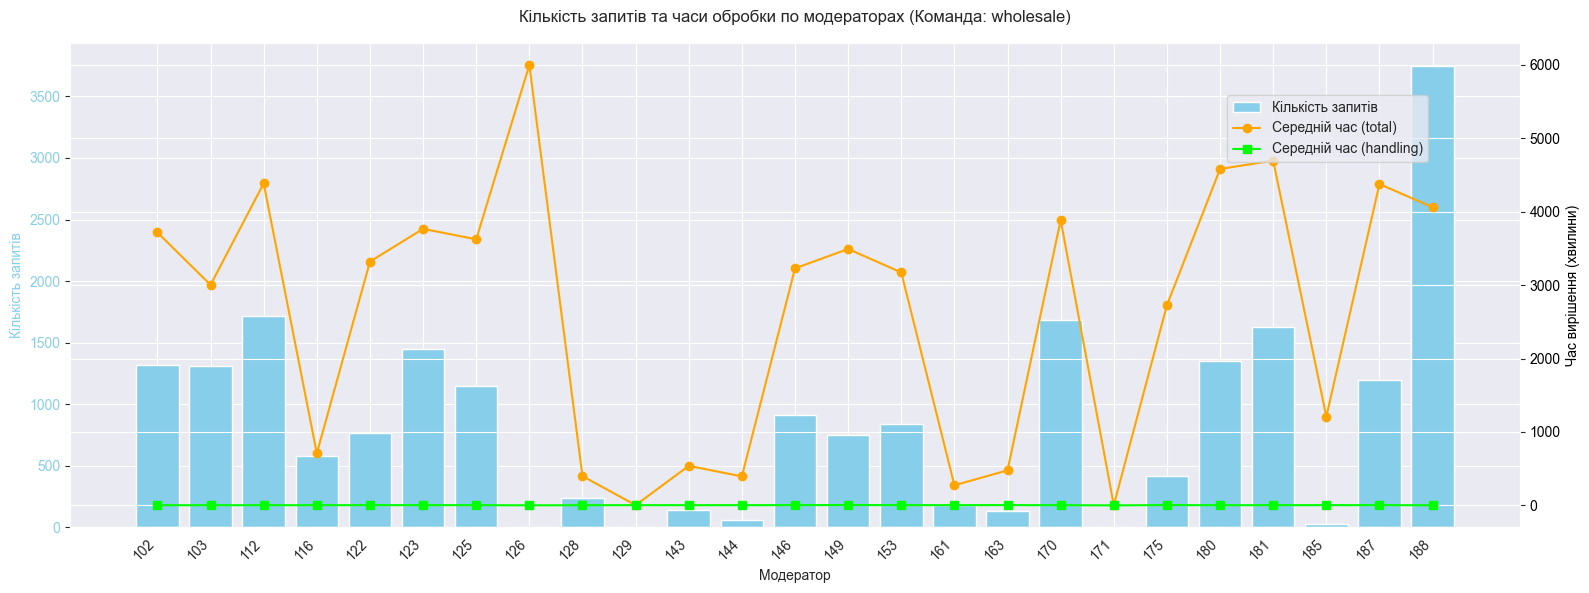

In [64]:
moderator_summary = df.groupby(['team', 'moderator']).agg(
    total_requests=('moderator', 'count'),
    avg_handling_time=('handling_time', 'mean'),
    avg_total_time=('total_time', 'mean')
).reset_index()

teams = moderator_summary["team"].unique()

for team in teams:
    team_data = moderator_summary[moderator_summary["team"] == team]

    moderators = team_data["moderator"].tolist()
    x = np.arange(len(moderators))

    fig, ax1 = plt.subplots(figsize=(16, 6))

    ax1.bar(x, team_data["total_requests"], color="skyblue", label="Кількість запитів")
    ax1.set_ylabel("Кількість запитів", color="skyblue")
    ax1.tick_params(axis='y', labelcolor="skyblue")
    ax1.set_xlabel("Модератор")
    ax1.set_xticks(x)
    ax1.set_xticklabels(moderators, rotation=45, ha="right")

    ax2 = ax1.twinx()
    ax2.plot(x, team_data["avg_total_time"], label="Середній час (total)", color="orange", marker='o')
    ax2.plot(x, team_data["avg_handling_time"], label="Середній час (handling)", color="lime", marker='s')
    ax2.set_ylabel("Час вирішення (хвилини)", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    fig.suptitle(f"Кількість запитів та часи обробки по модераторах (Команда: {team})")
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))
    plt.tight_layout()
    plt.show()


C:\Users\Юля\AppData\Local\Temp\ipykernel_5452\439849070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


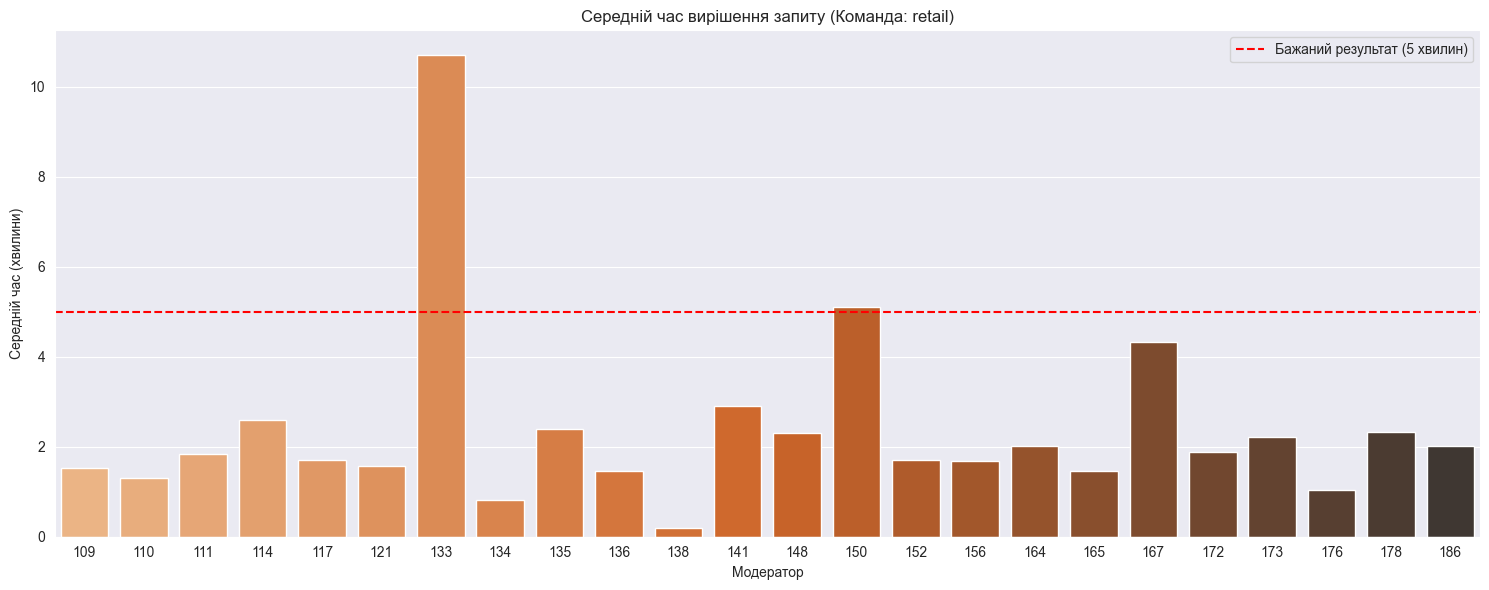

C:\Users\Юля\AppData\Local\Temp\ipykernel_5452\439849070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


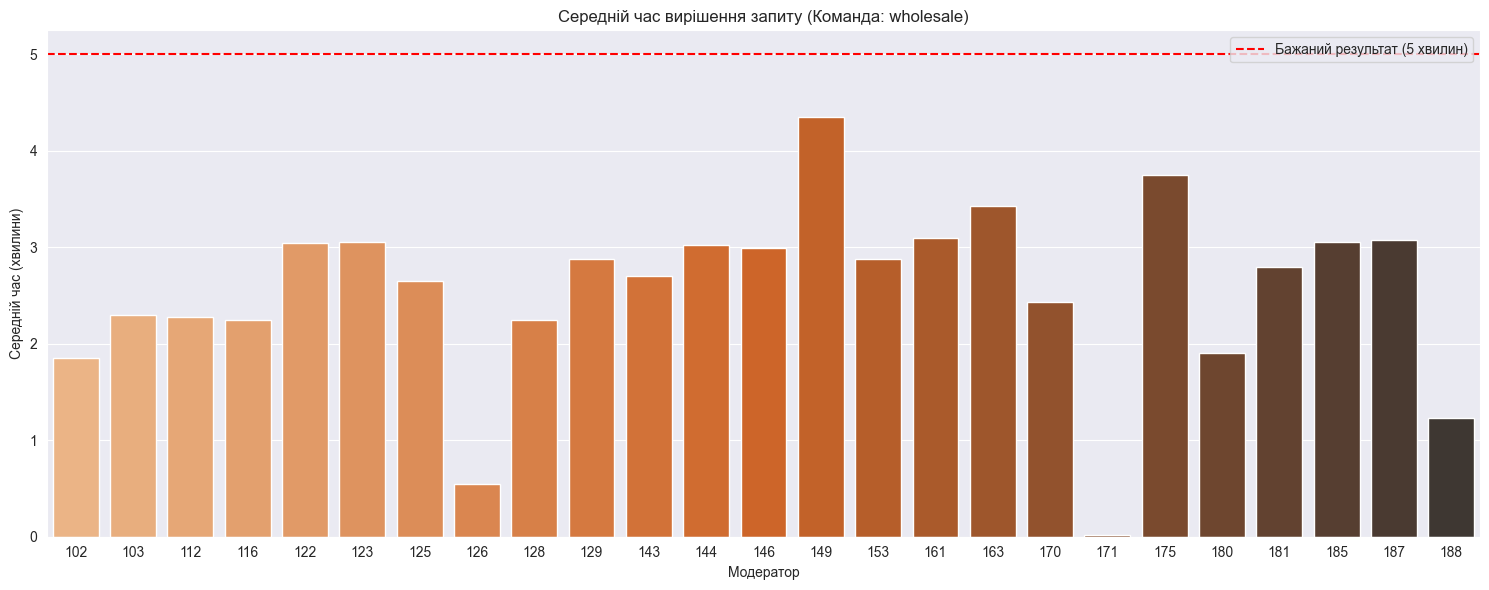

In [66]:
teams = moderator_summary['team'].unique()

for team in teams:
    plt.figure(figsize=(15, 6))
    team_data = moderator_summary[moderator_summary['team'] == team]

    sns.barplot(
        x="moderator",
        y="avg_handling_time",
        data=team_data.sort_values("avg_handling_time", ascending=False),
        palette="Oranges_d"
    )

    plt.title(f"Середній час вирішення запиту (Команда: {team})")
    plt.xlabel("Модератор")
    plt.ylabel("Середній час (хвилини)")

    # Лінія бажаного часу — 5 хвилин
    plt.axhline(y=5, color='red', linestyle='--', label='Бажаний результат (5 хвилин)')

    plt.legend()
    plt.tight_layout()
    plt.show()
